# Intro
In this notebook we'll develop a lagged MLP for predictive maintenance on FD002 to predict the Remaining Useful Life (RUL) of the engines. FD002 is characterized by the engines running on different operating conditions (see metadata below). You can find a full explanation of the code in my accompanying blogpost [here](https://towardsdatascience.com/lagged-mlp-for-predictive-maintenance-of-turbofan-engines-c79f02a15329?sk=84c2225e20760c04e9f27234c3803175).

Data Set: FD002  
Train trjectories: 260  
Test trajectories: 259  
Conditions: SIX  
Fault Modes: ONE (HPC Degradation)  

<disclaimer: I aim to showcase the effect of different methods and choices made during model development. These effects are often shown using the test set, something which is considered (very) bad practice but helps for educational purposes.>

In [1]:
%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

## important: set random seeds to get reproducible results
Initial weights of neural networks are generated randomly. Due to this randomness results may vary across training cycles, making it very difficult to judge whether the changes in model performance are because of this randomness or actuall improvements. Therefore we wan't to control the random initialization to allow comparing between iterations.  

#### Find a more thorough explanation on getting reproducible results [here](link)

In [3]:
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Load data

In [4]:
dir_path = './CMAPSSData/'
train_file = 'train_FD002.txt'
test_file = 'test_FD002.txt'
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD002.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

In [5]:
print(train.shape)
train.head()

(53759, 26)


unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    34.9983     0.8400      100.0  449.44  555.32   
1        1            2    41.9982     0.8408      100.0  445.00  549.90   
2        1            3    24.9988     0.6218       60.0  462.54  537.31   
3        1            4    42.0077     0.8416      100.0  445.00  549.51   
4        1            5    25.0005     0.6203       60.0  462.54  537.07   

       s_3      s_4   s_5  ...    s_12     s_13     s_14     s_15  s_16  s_17  \
0  1358.61  1137.23  5.48  ...  183.06  2387.72  8048.56   9.3461  0.02   334   
1  1353.22  1125.78  3.91  ...  130.42  2387.66  8072.30   9.3774  0.02   330   
2  1256.76  1047.45  7.05  ...  164.22  2028.03  7864.87  10.8941  0.02   309   
3  1354.03  1126.38  3.91  ...  130.72  2387.61  8068.66   9.3528  0.02   329   
4  1257.71  1047.93  7.05  ...  164.31  2028.00  7861.23  10.8963  0.02   309   

   s_18    s_19   s_20    s_21  
0  2223  100.00  14.73  8.8071  
1  2212  100.00  10.41  6.2665  
2  1915   84.93  14.08  8.6723  
3  2212  100.00  10.59  6.4701  
4  1915   84.93  14.13  8.5286  

[5 rows x 26 columns]

In [6]:
# before we start EDA, let's add RUL
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  148
1        1            2  147
2        1            3  146
3        1            4  145
4        1            5  144

# EDA
We can repeat a lot of the steps from our EDA on FD001

In [7]:
# inspect unit_nr
train[index_names].describe()

unit_nr   time_cycles
count  53759.000000  53759.000000
mean     131.082981    109.154746
std       74.463862     69.180569
min        1.000000      1.000000
25%       68.000000     52.000000
50%      131.000000    104.000000
75%      195.000000    157.000000
max      260.000000    378.000000

In [8]:
# inspect time cycles
train[index_names].groupby('unit_nr').max().describe()

time_cycles
count   260.000000
mean    206.765385
std      46.782198
min     128.000000
25%     174.000000
50%     199.000000
75%     230.250000
max     378.000000

In [9]:
# inspect sensor values, specifically if there are any with near 0 standard deviation 
# (sensors readings which do not change over time hold no information)
train[sensor_names].describe().transpose()

count         mean         std        min        25%        50%  \
s_1   53759.0   472.910207   26.389707   445.0000   445.0000   462.5400   
s_2   53759.0   579.672399   37.289399   535.5300   549.5700   555.9800   
s_3   53759.0  1419.971013  105.946341  1243.7300  1352.7600  1369.1800   
s_4   53759.0  1205.442024  119.123428  1023.7700  1123.6550  1138.8900   
s_5   53759.0     8.031986    3.613839     3.9100     3.9100     7.0500   
s_6   53759.0    11.600746    5.431802     5.7100     5.7200     9.0300   
s_7   53759.0   282.606787  146.005306   136.8000   139.9350   194.6600   
s_8   53759.0  2228.879188  145.209816  1914.7700  2211.8800  2223.0700   
s_9   53759.0  8525.200837  335.812013  7985.5600  8321.6600  8361.2000   
s_10  53759.0     1.094962    0.127469     0.9300     1.0200     1.0200   
s_11  53759.0    42.985172    3.232372    36.2300    41.9100    42.3900   
s_12  53759.0   266.069034  137.659507   129.1200   131.5200   183.2000   
s_13  53759.0  2334.557253  128.068271  2027.6100  2387.9000  2388.0800   
s_14  53759.0  8066.597682   84.837950  7848.3600  8062.1400  8082.5400   
s_15  53759.0     9.329654    0.749335     8.3357     8.6778     9.3109   
s_16  53759.0     0.023326    0.004711     0.0200     0.0200     0.0200   
s_17  53759.0   348.309511   27.754515   303.0000   331.0000   335.0000   
s_18  53759.0  2228.806358  145.327980  1915.0000  2212.0000  2223.0000   
s_19  53759.0    97.756838    5.364067    84.9300   100.0000   100.0000   
s_20  53759.0    20.789296    9.869331    10.1800    10.9100    14.8800   
s_21  53759.0    12.473423    5.921615     6.0105     6.5463     8.9292   

            75%        max  
s_1    491.1900   518.6700  
s_2    607.3400   644.5200  
s_3   1499.3700  1612.8800  
s_4   1306.8500  1439.2300  
s_5     10.5200    14.6200  
s_6     15.4900    21.6100  
s_7    394.0800   555.8200  
s_8   2323.9600  2388.3900  
s_9   8778.0300  9215.6600  
s_10     1.2600     1.3000  
s_11    45.3500    48.5100  
s_12   371.2600   523.3700  
s_13  2388.1700  2390.4800  
s_14  8127.1950  8268.5000  
s_15     9.3869    11.0669  
s_16     0.0300     0.0300  
s_17   369.0000   399.0000  
s_18  2324.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    28.4700    39.3400  
s_21    17.0832    23.5901

In [10]:
# inspect settings
train[setting_names].describe()

setting_1     setting_2     setting_3
count  53759.000000  53759.000000  53759.000000
mean      23.998407      0.572056     94.046020
std       14.747376      0.310016     14.237735
min        0.000000      0.000000     60.000000
25%       10.004600      0.250700    100.000000
50%       25.001300      0.700000    100.000000
75%       41.998000      0.840000    100.000000
max       42.008000      0.842000    100.000000

In [11]:
print(train['setting_1'].round().unique())
print(train['setting_2'].round(decimals=2).unique())
print(train['setting_3'].unique())

[35. 42. 25. 20.  0. 10.]
[0.84 0.62 0.7  0.   0.25]
[100.  60.]


In [12]:
# check unique combinations
settings_df = train[setting_names].copy()
settings_df['setting_1'] = settings_df['setting_1'].round()
settings_df['setting_2'] = settings_df['setting_2'].round(decimals=2)
settings_df.groupby(by=setting_names).size()

setting_1  setting_2  setting_3
0.0        0.00       100.0         8044
10.0       0.25       100.0         8096
20.0       0.70       100.0         8122
25.0       0.62       60.0          8002
35.0       0.84       100.0         8037
42.0       0.84       100.0        13458
dtype: int64

The presence of six unique operating conditions can be confirmed, one operating condition occurs more often that the others but otherwise it's pretty balanced

# Plotting

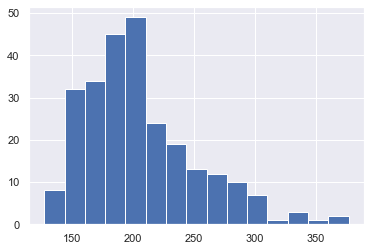

In [13]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').first().reset_index()
df_max_rul['RUL'].hist(bins=15)
plt.show()

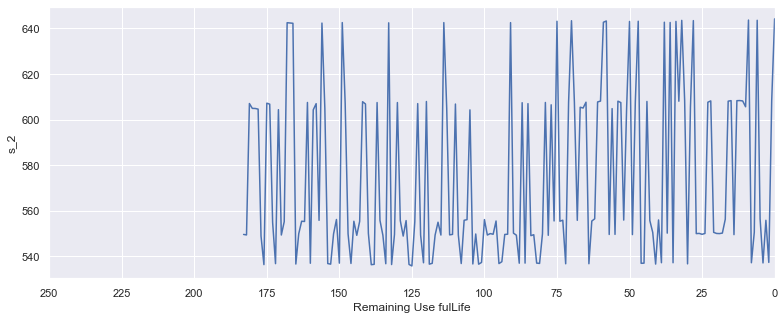

In [14]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    
    if unit_nr:
        plt.plot('RUL', signal_name, 
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name, 
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

# specifically plotting s_2, I'm using this as an example throughout the rest of the analysis  
plot_signal(train, 's_2', unit_nr=10)

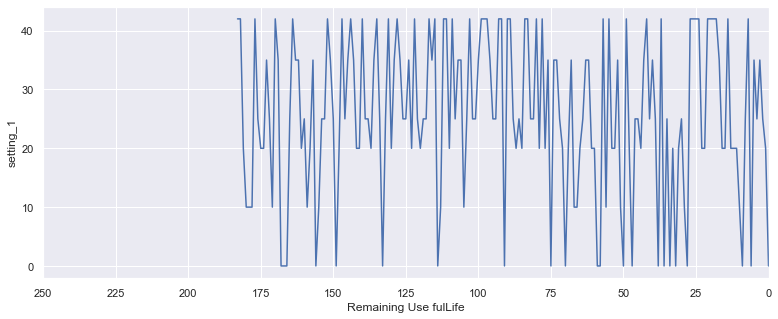

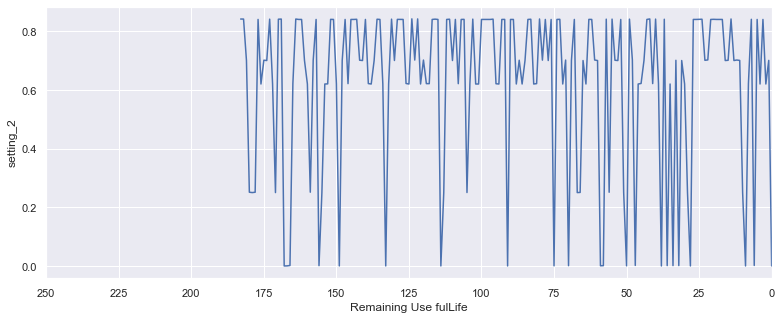

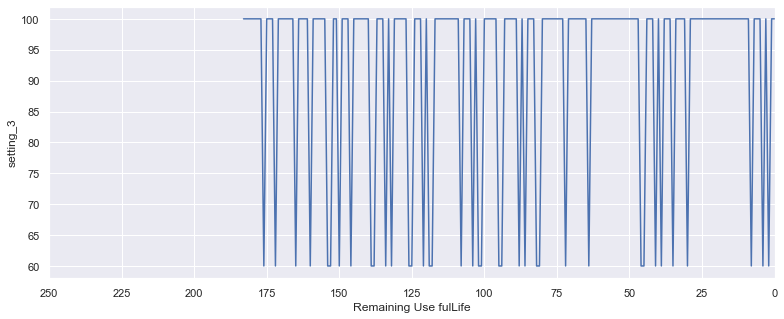

In [15]:
for setting in setting_names:
    plot_signal(train, setting, unit_nr=10)

Plotting won't do us much good here. Since the operating settings change between cycles, it becomes impossible to identify visual trends. We'll implement some preprocessing later

# Baseline model

In [16]:
X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy() # get last row of each engine

In [17]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [18]:
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.94192340996904, R2:0.7226666213449306
test set RMSE:32.64244063056574, R2:0.6315800619887212


# Validation set

In [19]:
from sklearn.model_selection import GroupShuffleSplit

In [20]:
# eventhough we set np and tf seeds, gss requires its own seed
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

split_result = train_val_group_split(X_train, y_train_clipped, gss, train['unit_nr'])
X_train_split, y_train_clipped_split, X_val_split, y_val_clipped_split = split_result

train_split_engines [  1   2   3   4   5   6   8   9  12  13  14  15  17  18  21  22  23  24
  27  28  29  30  32  33  35  36  37  38  39  40  41  42  43  44  45  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  70  71  72  73  74  75  77  79  80  81  82  83  84  85  86  87
  88  89  90  92  94  95  96  99 100 101 103 104 106 107 108 109 110 111
 112 113 116 117 118 119 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 141 142 144 146 147 148 149 150 152 153 154
 156 157 158 160 161 162 163 164 165 166 167 169 170 171 172 173 175 176
 177 179 181 183 184 185 187 188 189 190 192 193 194 195 196 198 199 200
 201 203 204 208 209 210 211 215 216 217 218 219 220 222 223 225 226 227
 228 230 231 232 233 234 235 236 239 240 241 242 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 260] 

validate_split_engines [  7  10  11  16  19  20  25  26  31  34  46  47  69  76  78  91  93  97
  98 102 105 114 115 120 140 143 145 

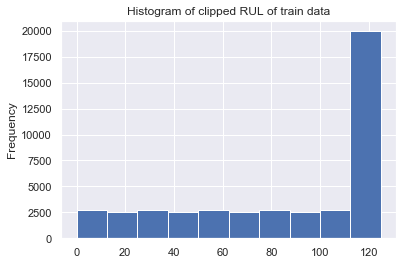

In [25]:
plt.figure()
y_train_clipped_split.plot(kind='hist')
plt.title("Histogram of clipped RUL of train data")
plt.show()
plt.close()

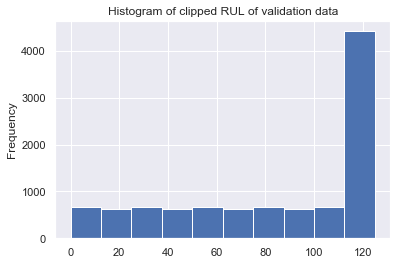

In [26]:
plt.figure()
y_val_clipped_split.plot(kind='hist')
plt.title("Histogram of clipped RUL of validation data")
plt.show()
plt.close()

Although the frequency is lower, the distribution of validation RUL looks similar to the training RUL

# MLP

In [22]:
train_cols = setting_names+sensor_names
input_dim = len(train_cols)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('initial_weights_simple_mlp.h5')  

In [24]:
epochs = 20

# reset initial optimizer parameters by recompiling model
# and reset initial model weights to allow repeated running of cell with consistent results
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('initial_weights_simple_mlp.h5')

history = model.fit(X_train_split[train_cols], y_train_clipped_split,
                    validation_data=(X_val_split[train_cols], y_val_clipped_split),
                    epochs=epochs)

Train on 43464 samples, validate on 10295 samples
Epoch 1/20
43464/43464 [==============================] - 3s 70us/sample - loss: 2047.4274 - val_loss: 1864.8116
Epoch 2/20
43464/43464 [==============================] - 3s 59us/sample - loss: 1800.5968 - val_loss: 1835.0577
Epoch 3/20
43464/43464 [==============================] - 2s 56us/sample - loss: 1764.3037 - val_loss: 1736.7065
Epoch 4/20
43464/43464 [==============================] - 2s 56us/sample - loss: 1738.9914 - val_loss: 1724.6732
Epoch 5/20
43464/43464 [==============================] - 2s 57us/sample - loss: 1725.0060 - val_loss: 1712.5795
Epoch 6/20
43464/43464 [==============================] - 2s 57us/sample - loss: 1704.0283 - val_loss: 1775.8898
Epoch 7/20
43464/43464 [==============================] - 3s 58us/sample - loss: 1676.8656 - val_loss: 1617.8852
Epoch 8/20
43464/43464 [==============================] - 2s 56us/sample - loss: 1652.8624 - val_loss: 1622.9671
Epoch 9/20
43464/43464 [======================

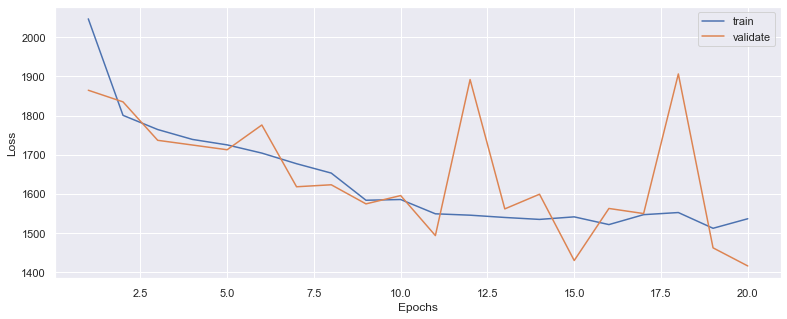

In [25]:
# plot history

def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [26]:
# predict and evaluate
y_hat_train = model.predict(X_train[train_cols])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = model.predict(X_test[train_cols])
evaluate(y_test, y_hat_test)

train set RMSE:37.7928346233896, R2:0.17724280834066286
test set RMSE:48.75293917276738, R2:0.17817474021106527


# Scaling
Just like with the SVR, NNs tend to use relative distances between data points, but are not very well in comprehending the magnitude of absolute differences. Therefore, adding scaling will drastically improve results

In [27]:
# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(X_train[sensor_names])
X_train_scaled = X_train.copy()
X_train_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_train[sensor_names]), columns=sensor_names)


X_test_scaled = X_test.copy()
X_test_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_test[sensor_names]), columns=sensor_names, index=X_test.index)
# set index because unit_nr begins at 1 instead of 0

In [28]:
split_result = train_val_group_split(X_train_scaled, y_train_clipped, gss, train['unit_nr'], print_groups=True)
X_train_split_scaled, y_train_clipped_split_scaled, X_val_split_scaled, y_val_clipped_split_scaled = split_result

train_split_engines [  1   2   3   4   5   6   8   9  12  13  14  15  17  18  21  22  23  24
  27  28  29  30  32  33  35  36  37  38  39  40  41  42  43  44  45  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  70  71  72  73  74  75  77  79  80  81  82  83  84  85  86  87
  88  89  90  92  94  95  96  99 100 101 103 104 106 107 108 109 110 111
 112 113 116 117 118 119 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 141 142 144 146 147 148 149 150 152 153 154
 156 157 158 160 161 162 163 164 165 166 167 169 170 171 172 173 175 176
 177 179 181 183 184 185 187 188 189 190 192 193 194 195 196 198 199 200
 201 203 204 208 209 210 211 215 216 217 218 219 220 222 223 225 226 227
 228 230 231 232 233 234 235 236 239 240 241 242 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 260] 

validate_split_engines [  7  10  11  16  19  20  25  26  31  34  46  47  69  76  78  91  93  97
  98 102 105 114 115 120 140 143 145 

Note, the train-validation split is exactly the same as in our first attempt

In [29]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('initial_weights_simple_mlp.h5')

history = model.fit(X_train_split_scaled[train_cols], y_train_clipped_split_scaled,
                    validation_data=(X_val_split_scaled[train_cols], y_val_clipped_split_scaled),
                    epochs=epochs)

Train on 43464 samples, validate on 10295 samples
Epoch 1/20
43464/43464 [==============================] - 4s 102us/sample - loss: 1942.2808 - val_loss: 1807.7369
Epoch 2/20
43464/43464 [==============================] - 3s 66us/sample - loss: 1722.9574 - val_loss: 1695.9222
Epoch 3/20
43464/43464 [==============================] - 3s 61us/sample - loss: 1663.9086 - val_loss: 1649.3933
Epoch 4/20
43464/43464 [==============================] - 4s 84us/sample - loss: 1607.8062 - val_loss: 1564.3409
Epoch 5/20
43464/43464 [==============================] - 4s 95us/sample - loss: 1508.7612 - val_loss: 1430.8553
Epoch 6/20
43464/43464 [==============================] - 3s 78us/sample - loss: 1394.2640 - val_loss: 1295.4561
Epoch 7/20
43464/43464 [==============================] - 4s 81us/sample - loss: 1245.7004 - val_loss: 1075.9676
Epoch 8/20
43464/43464 [==============================] - 3s 78us/sample - loss: 993.1918 - val_loss: 796.6105
Epoch 9/20
43464/43464 [=======================

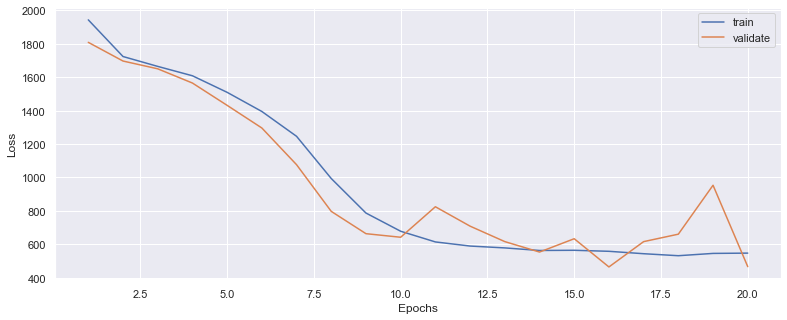

In [30]:
plot_loss(history)

In [31]:
# predict and evaluate
y_hat_train = model.predict(X_train_scaled[train_cols])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = model.predict(X_test_scaled[train_cols])
evaluate(y_test, y_hat_test)

train set RMSE:22.393854937161706, R2:0.7111246569724521
test set RMSE:34.00842713320483, R2:0.600100397460153


# One hot encoding
[explanation ] 
Technically, one hot encoding keeps all values as columns, while dummy encoding drops the first or last column because the information is redundant. (Google it)


In [32]:
# first round the setting values to make sure they're interpreted as 6 unique combinations
X_train_condition = X_train.copy()
X_train_condition['setting_1'] = X_train_condition['setting_1'].round()
X_train_condition['setting_2'] = X_train_condition['setting_2'].round(decimals=2)

# converting settings to string and concatanating makes the operating condition into a categorical variable
X_train_condition['op_cond'] = X_train_condition['setting_1'].astype(str) + '_' + \
                        X_train_condition['setting_2'].astype(str) + '_' + \
                        X_train_condition['setting_3'].astype(str)

op_cond = list(X_train_condition['op_cond'].unique())
op_cond

['35.0_0.84_100.0',
 '42.0_0.84_100.0',
 '25.0_0.62_60.0',
 '20.0_0.7_100.0',
 '0.0_0.0_100.0',
 '10.0_0.25_100.0']

In [33]:
pd.get_dummies(X_train_condition['op_cond'], drop_first=False).head()  # we can drop one column later

0.0_0.0_100.0  10.0_0.25_100.0  20.0_0.7_100.0  25.0_0.62_60.0  \
0              0                0               0               0   
1              0                0               0               0   
2              0                0               0               1   
3              0                0               0               0   
4              0                0               0               1   

   35.0_0.84_100.0  42.0_0.84_100.0  
0                1                0  
1                0                1  
2                0                0  
3                0                1  
4                0                0

In [34]:
X_train_scaled_encoded = X_train_scaled.merge(pd.get_dummies(X_train_condition['op_cond'], drop_first=True), left_index=True, right_index=True)
X_train_scaled_encoded.drop(labels=setting_names, axis=1, inplace=True)
X_train_scaled_encoded.head()

s_1       s_2       s_3       s_4       s_5       s_6       s_7  \
0  0.060269  0.181576  0.311201  0.273095  0.146592  0.144025  0.138036   
1  0.000000  0.131847  0.296600  0.245535  0.000000  0.000000  0.004081   
2  0.238089  0.016332  0.035297  0.056997  0.293184  0.208176  0.092860   
3  0.000000  0.128269  0.298795  0.246979  0.000000  0.000000  0.003962   
4  0.238089  0.014130  0.037871  0.058152  0.293184  0.208805  0.091284   

        s_8       s_9      s_10  ...      s_17      s_18  s_19      s_20  \
0  0.650057  0.289692  0.243243  ...  0.322917  0.651163   1.0  0.156036   
1  0.626663  0.258841  0.243243  ...  0.281250  0.627907   1.0  0.007888   
2  0.000718  0.012893  0.027027  ...  0.062500  0.000000   0.0  0.133745   
3  0.626684  0.258841  0.243243  ...  0.270833  0.627907   1.0  0.014060   
4  0.000697  0.006235  0.027027  ...  0.062500  0.000000   0.0  0.135460   

       s_21  10.0_0.25_100.0  20.0_0.7_100.0  25.0_0.62_60.0  35.0_0.84_100.0  \
0  0.159082                0               0               0                1   
1  0.014562                0               0               0                0   
2  0.151414                0               0               1                0   
3  0.026144                0               0               0                0   
4  0.143240                0               0               1                0   

   42.0_0.84_100.0  
0                0  
1                1  
2                0  
3                1  
4                0  

[5 rows x 26 columns]

In [35]:
X_test_condition = X_test.copy()
X_test_condition['op_cond'] = X_test_condition['setting_1'].round().astype(str) + '_' + \
                        X_test_condition['setting_2'].round(2).astype(str) + '_' + \
                        X_test_condition['setting_3'].astype(str)
X_test_scaled_encoded = X_test_scaled.merge(pd.get_dummies(X_test_condition['op_cond'], drop_first=True), left_index=True, right_index=True)
X_test_scaled_encoded.drop(labels=setting_names, axis=1, inplace=True)

In [36]:
split_result = train_val_group_split(X_train_scaled_encoded, y_train_clipped, gss, train['unit_nr'], print_groups=False)
X_train_split_scaled_encoded, y_train_clipped_split_scaled_encoded = split_result[:2]
X_val_split_scaled_encoded, y_val_clipped_split_scaled_encoded = split_result[2:]

In [37]:
# we have to redefine our model as our inputs changed
input_dim = len(X_train_split_scaled_encoded.columns)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [38]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('one_hot_weights_mlp.h5')

In [39]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('one_hot_weights_mlp.h5')

history = model.fit(X_train_split_scaled_encoded, y_train_clipped_split_scaled_encoded,
                    validation_data=(X_val_split_scaled_encoded, y_val_clipped_split_scaled_encoded),
                    epochs=epochs)

Train on 43464 samples, validate on 10295 samples
Epoch 1/20
43464/43464 [==============================] - 3s 68us/sample - loss: 2149.7878 - val_loss: 1677.4113
Epoch 2/20
43464/43464 [==============================] - 3s 58us/sample - loss: 1557.2536 - val_loss: 1425.9080
Epoch 3/20
43464/43464 [==============================] - 3s 60us/sample - loss: 972.4644 - val_loss: 600.8085
Epoch 4/20
43464/43464 [==============================] - 2s 57us/sample - loss: 543.8084 - val_loss: 457.8757
Epoch 5/20
43464/43464 [==============================] - 2s 56us/sample - loss: 497.9367 - val_loss: 455.2949
Epoch 6/20
43464/43464 [==============================] - 3s 58us/sample - loss: 476.5515 - val_loss: 447.9407
Epoch 7/20
43464/43464 [==============================] - 2s 57us/sample - loss: 472.7937 - val_loss: 456.0034
Epoch 8/20
43464/43464 [==============================] - 3s 58us/sample - loss: 462.9183 - val_loss: 430.8367
Epoch 9/20
43464/43464 [==============================] - 

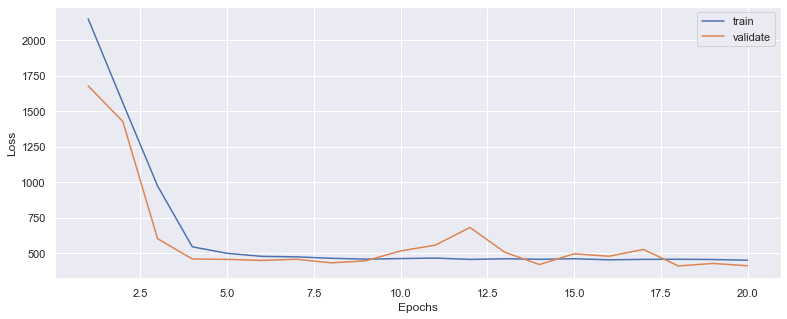

In [40]:
plot_loss(history)

In [41]:
# predict and evaluate
y_hat_train = model.predict(X_train_scaled_encoded)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = model.predict(X_test_scaled_encoded)
evaluate(y_test, y_hat_test)

train set RMSE:20.808243847608377, R2:0.750584401859277
test set RMSE:32.01317172432277, R2:0.6456476739830382


So, it works, but isn't as effective as I had hoped for. Plus, one-hot encoding limits our ability to implement additional feature engineering / preprocessing like smoothing and lagged variables. For a full explanation, please refer to the accompanying blogppost.

# Condition based standardization
#### Note: standardizing for each operating condition implies the assumption that the operating condition itself has no effect on time to failure but only affects the mean of the signals

In [42]:
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    
    return df_op_cond

In [43]:
X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(X_test)

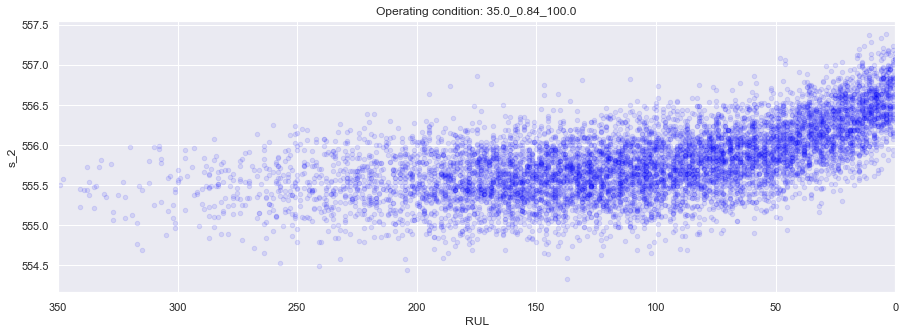

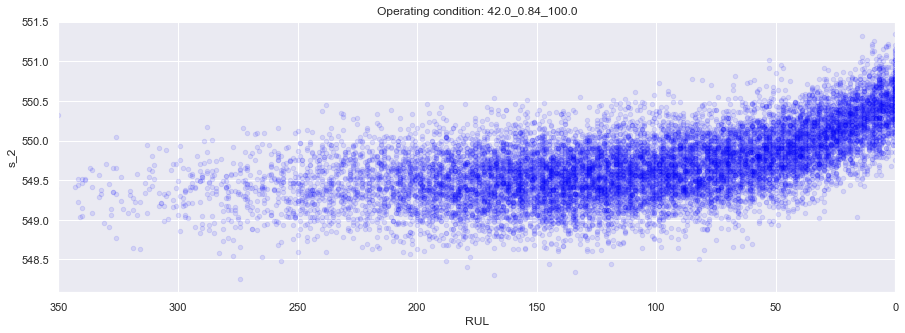

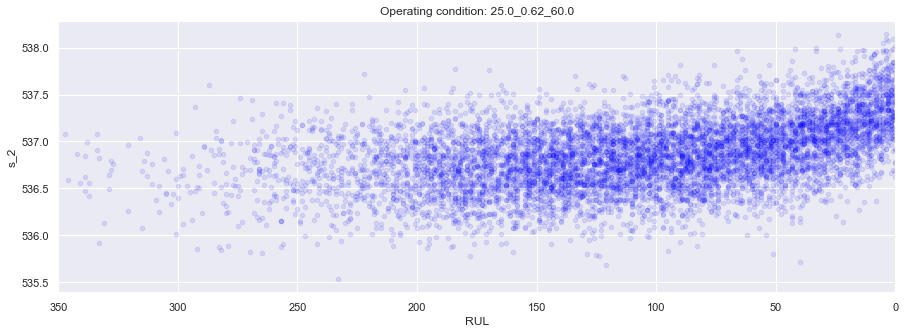

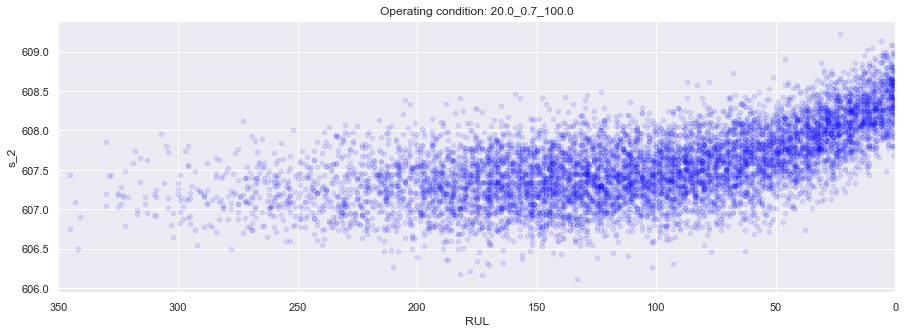

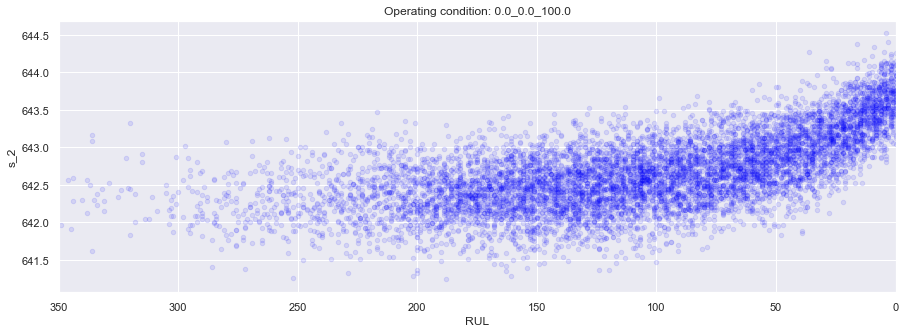

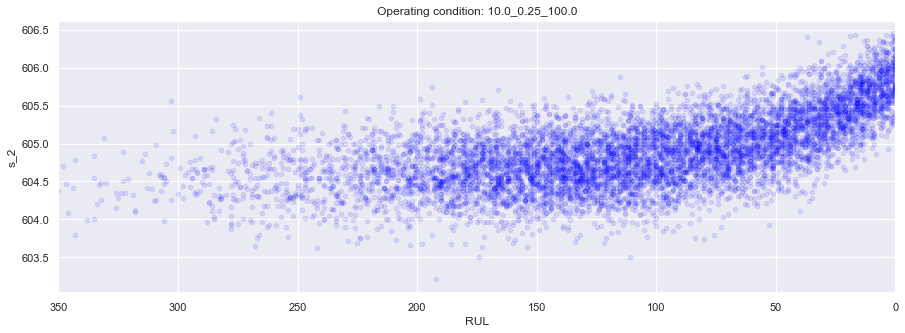

In [44]:
for condition in X_train_condition['op_cond'].unique():
    
    X_train_condition.loc[X_train_condition['op_cond'] == condition].plot(
        x='RUL', y='s_2', 
        kind='scatter', color='blue', 
        alpha=0.1, figsize=(15,5))
    plt.xlim(350, 0)
    plt.title(f"Operating condition: {condition}")
    plt.show()

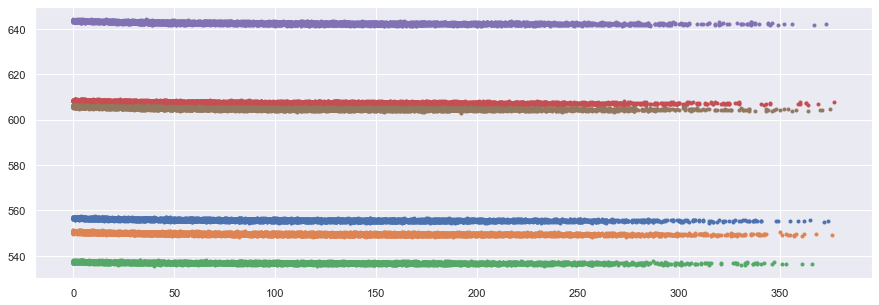

In [45]:
plt.figure(figsize=(15,5))

for condition in op_cond:
    data = X_train_condition.loc[X_train_condition['op_cond']==condition]
    plt.plot(data['RUL'], data['s_2'], '.')

In [46]:
def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [47]:
X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

In [48]:
X_test_condition_scaled.head()

setting_1  setting_2  setting_3  s_1       s_2       s_3       s_4  \
unit_nr                                                                       
1             10.0       0.25      100.0 -1.0  1.067757  2.243249  1.633786   
2              0.0       0.00      100.0  0.0 -0.017587  0.207384  1.041724   
3             35.0       0.84      100.0  1.0  0.138436  0.695713  0.548449   
4             20.0       0.70      100.0  1.0  0.918094  0.406796  0.560935   
5             42.0       0.84      100.0  0.0  2.553217  0.796509  1.641733   

         s_5       s_6       s_7  ...      s_13      s_14      s_15      s_16  \
unit_nr                           ...                                           
1        0.0  1.429549 -1.109478  ...  1.619153  1.993314  2.120741 -1.000000   
2       -1.0  0.131140 -0.000836  ...  0.290831 -0.214174 -0.472348 -1.000000   
3       -1.0 -0.174690  0.286740  ... -0.227555 -0.062787 -0.600083  1.000000   
4        1.0  0.713320 -0.176094  ... -0.263652 -0.232749  0.056746 -0.522151   
5        1.0  0.844057 -0.479111  ...  3.116996  3.125538  0.568977  1.000000   

             s_17  s_18  s_19      s_20      s_21          op_cond  
unit_nr                                                             
1        0.873173   0.0   0.0 -1.571362 -0.260551  10.0_0.25_100.0  
2       -0.130505   0.0   0.0  0.014174  0.533134    0.0_0.0_100.0  
3       -1.591890   0.0   0.0 -0.713689  0.908522  35.0_0.84_100.0  
4       -0.262250   0.0   0.0 -1.734068  0.108079   20.0_0.7_100.0  
5        1.372567   0.0   0.0 -2.283410  0.137583  42.0_0.84_100.0  

[5 rows x 25 columns]

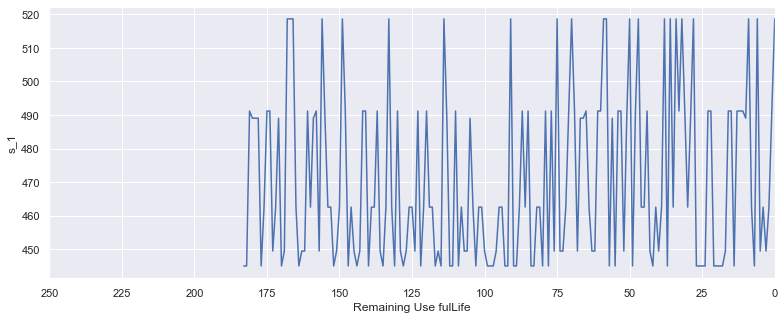

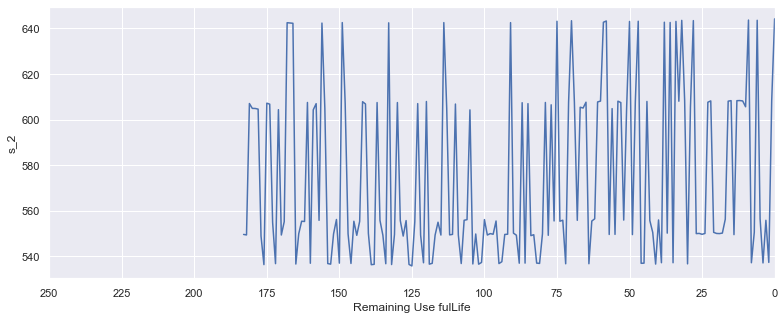

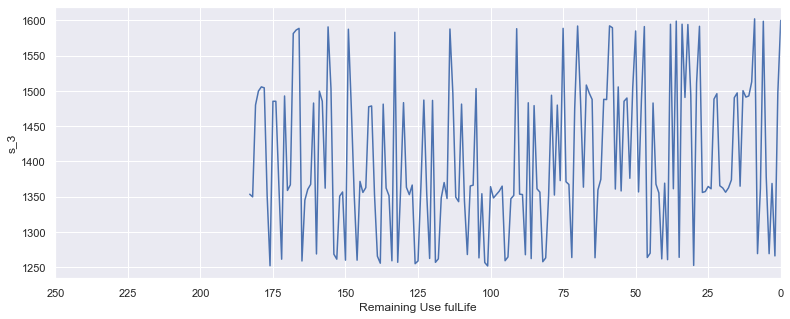

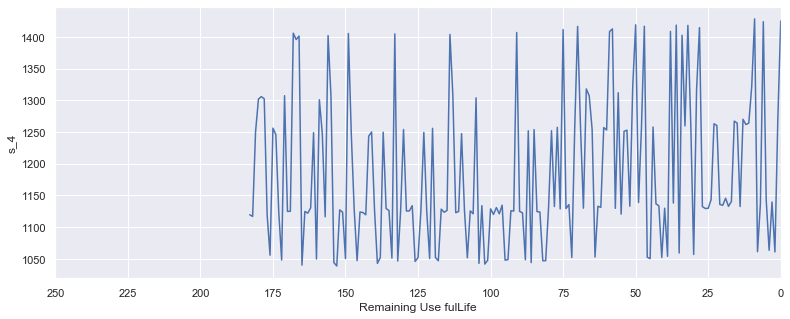

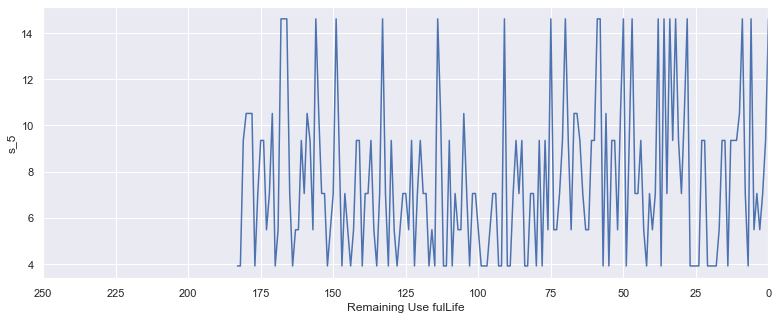

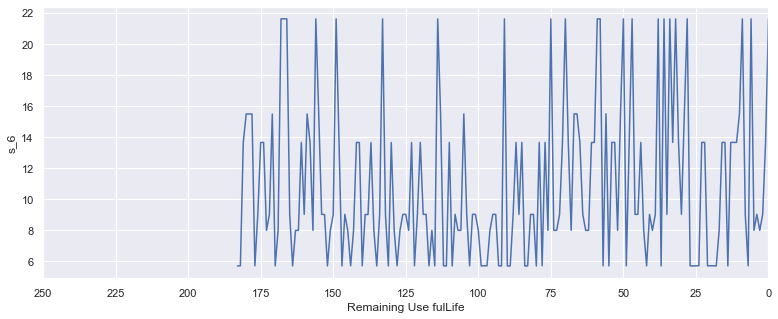

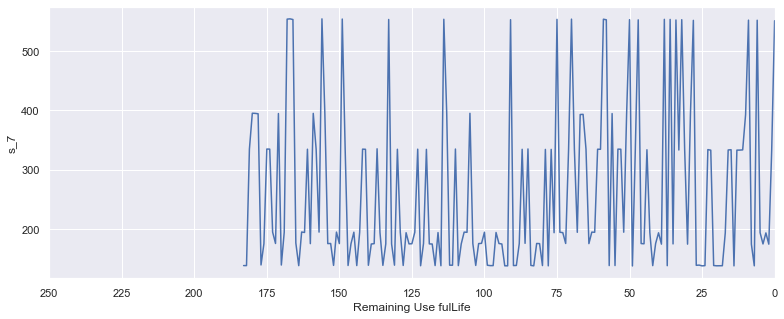

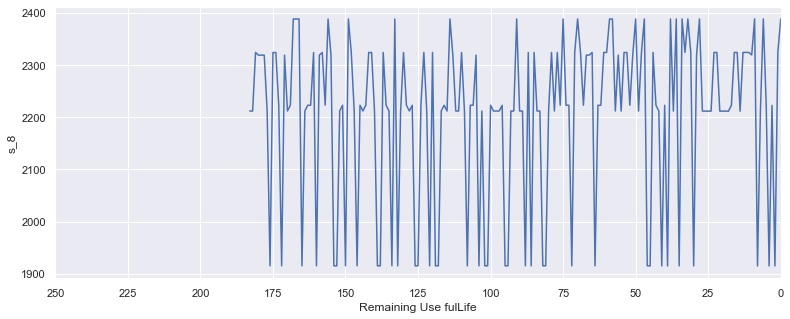

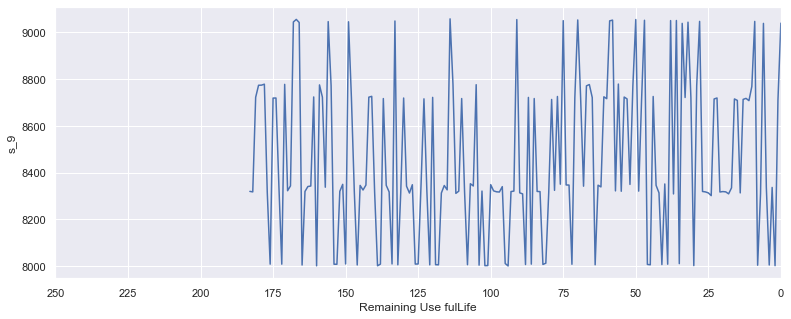

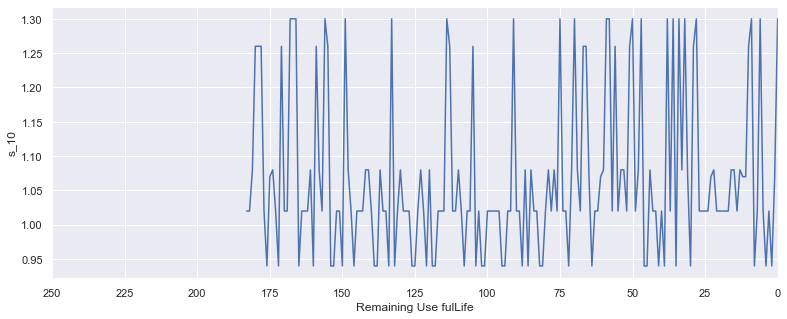

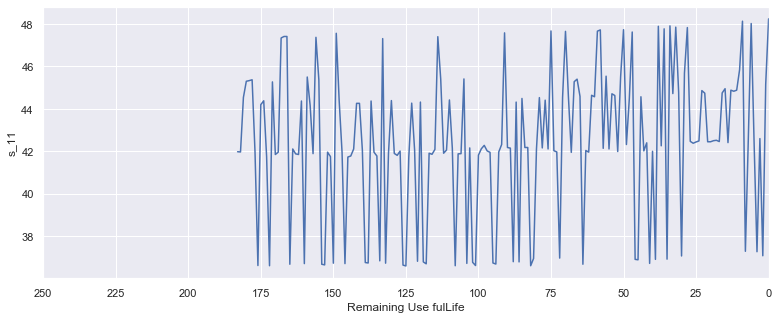

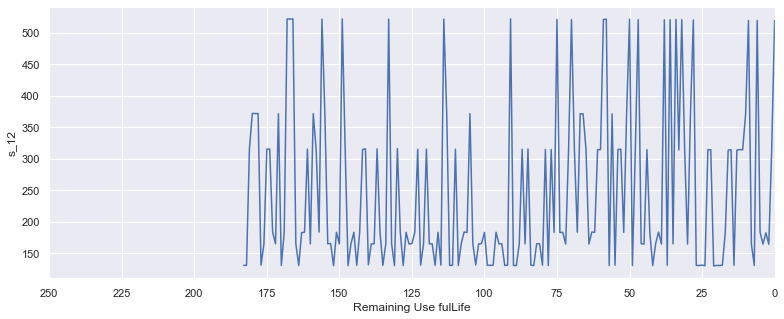

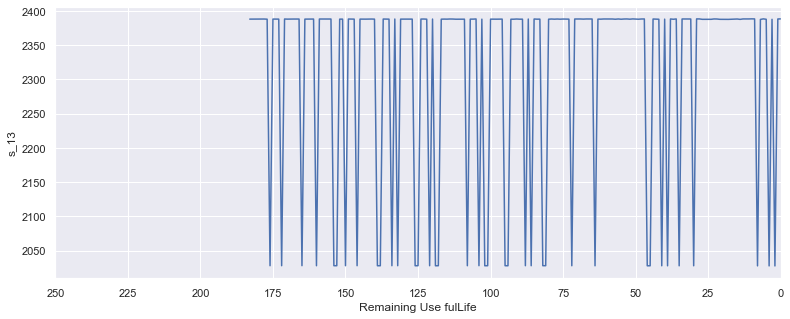

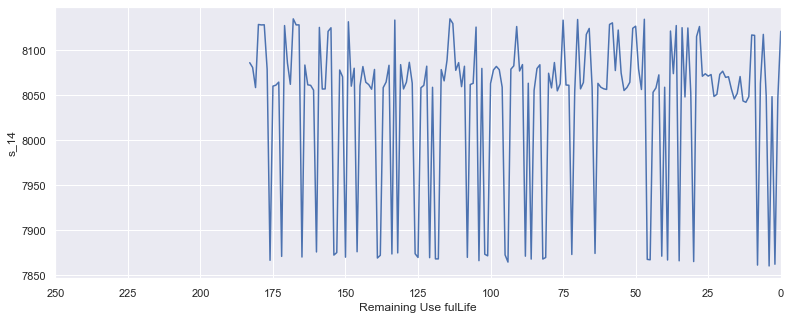

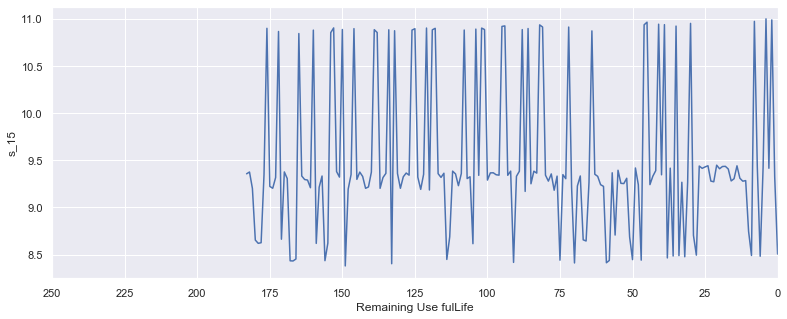

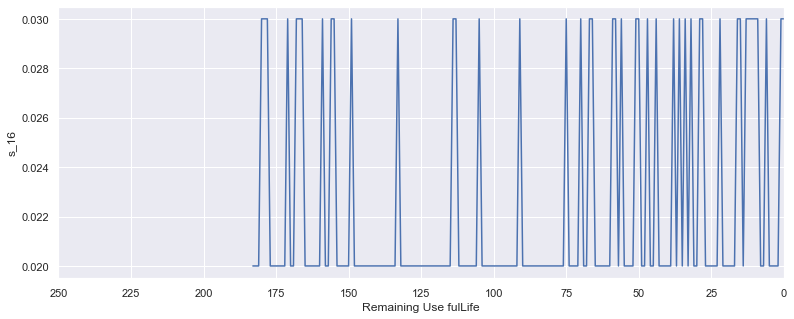

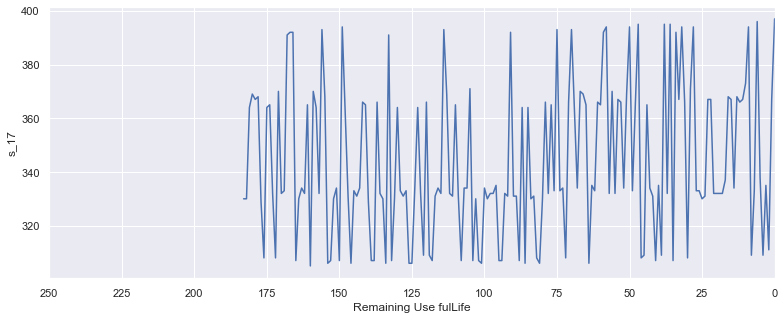

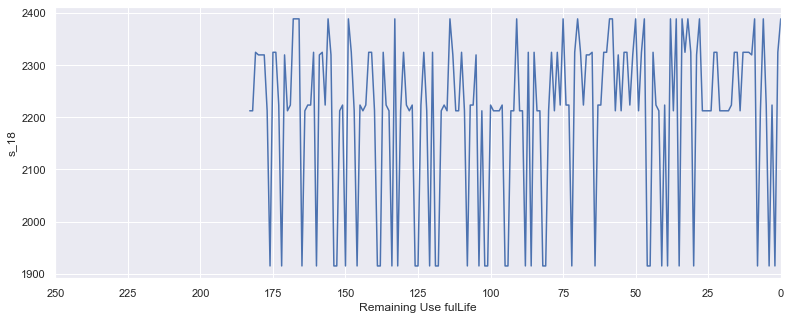

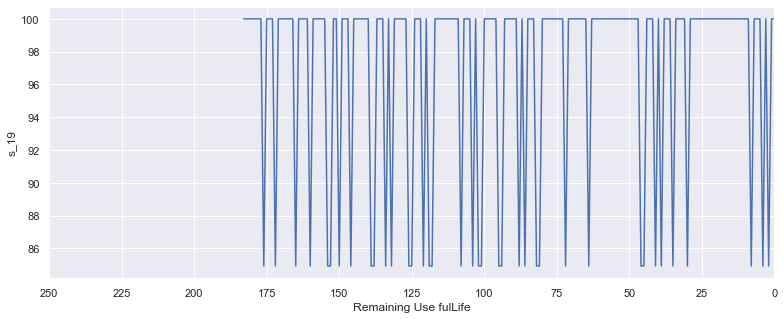

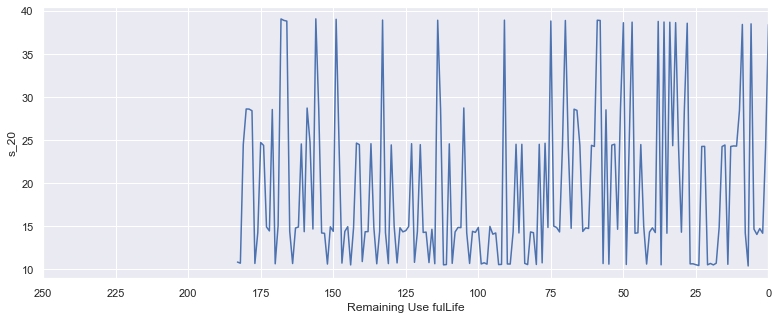

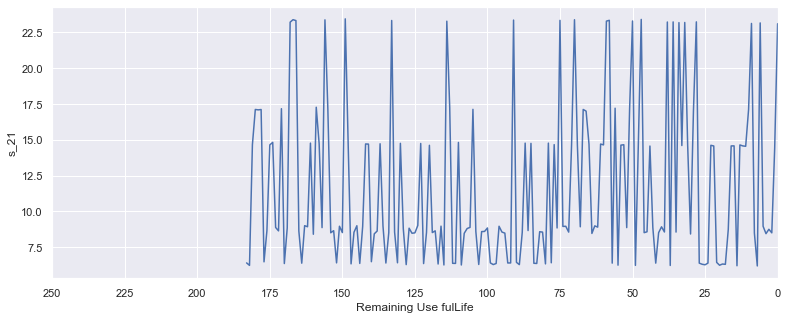

In [49]:
for sensor in sensor_names:  # compare train vs condition scaled
    plot_signal(train, sensor, unit_nr=10)

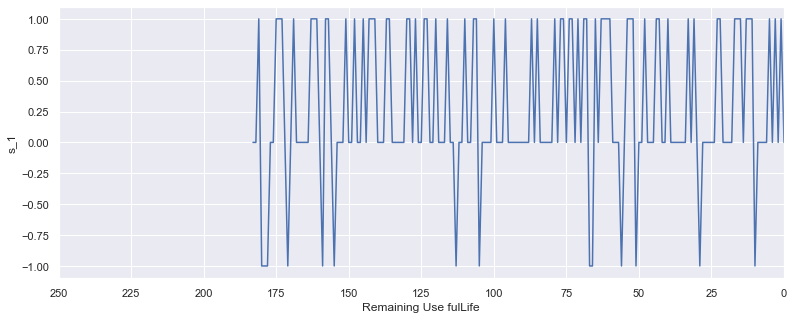

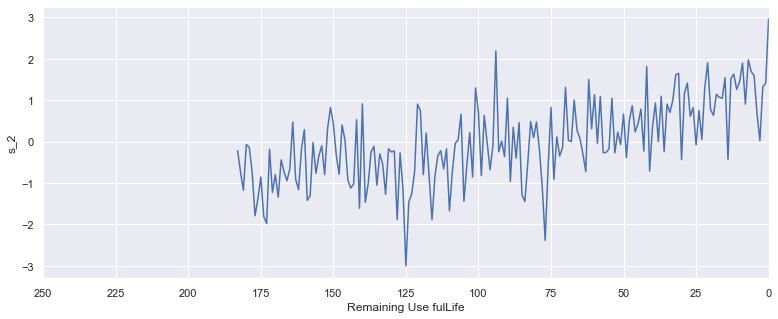

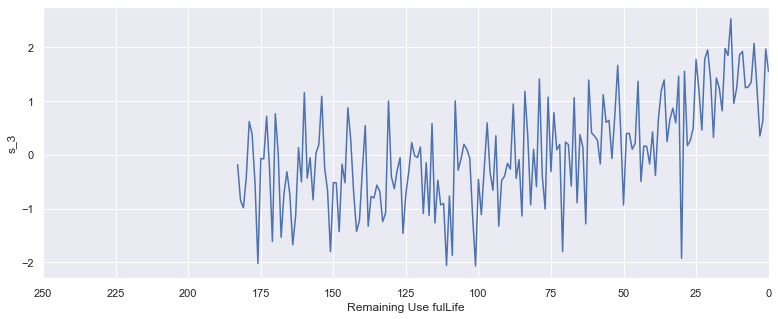

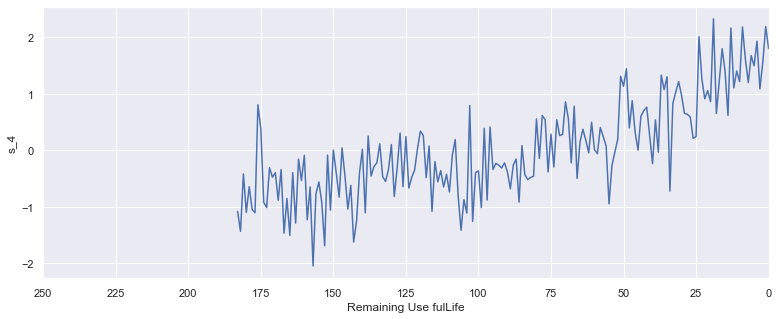

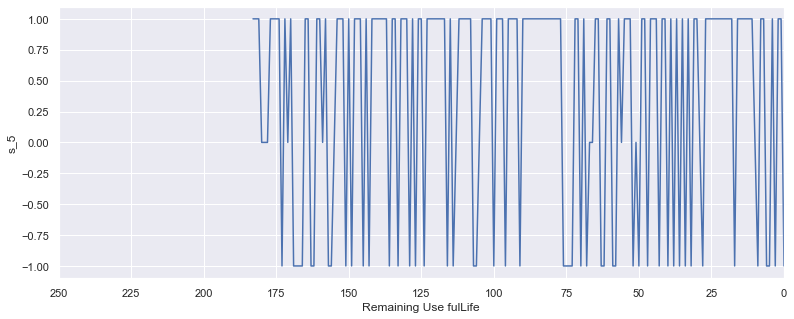

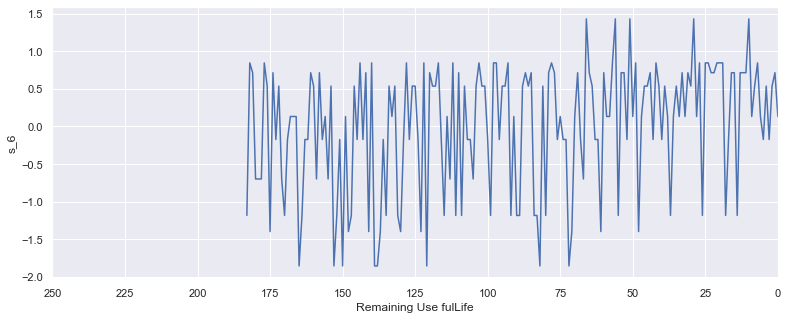

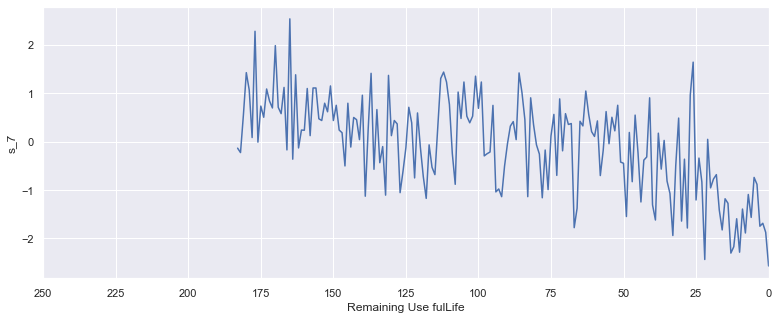

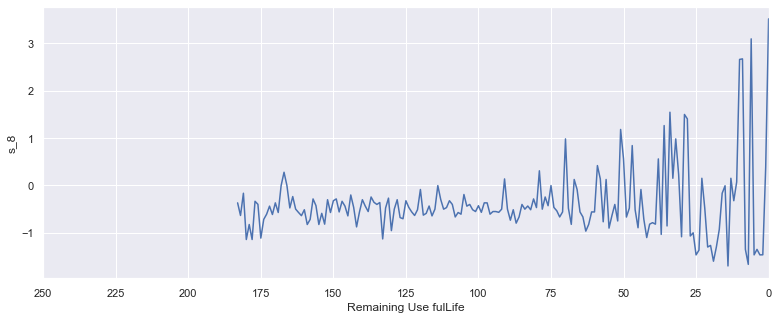

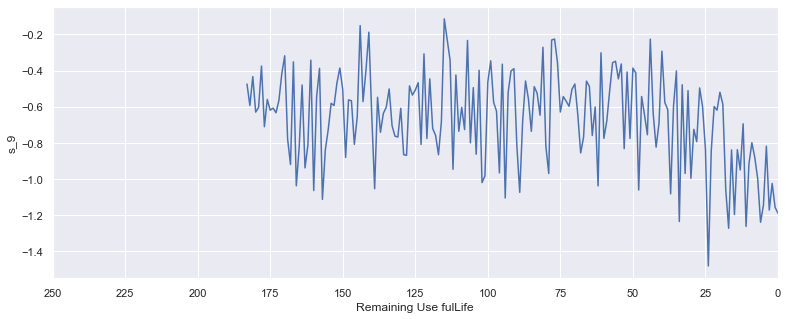

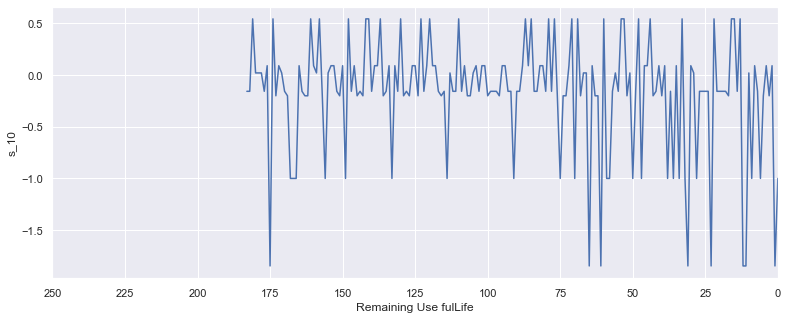

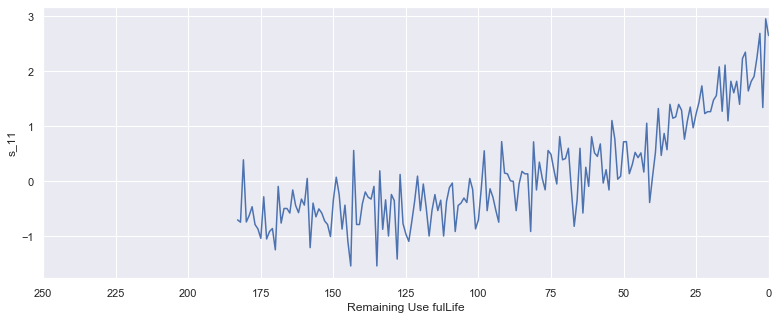

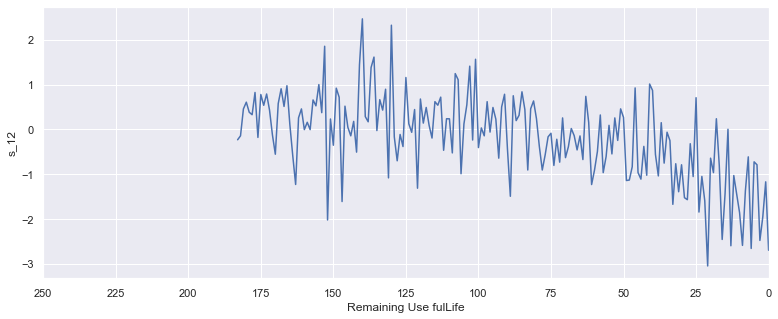

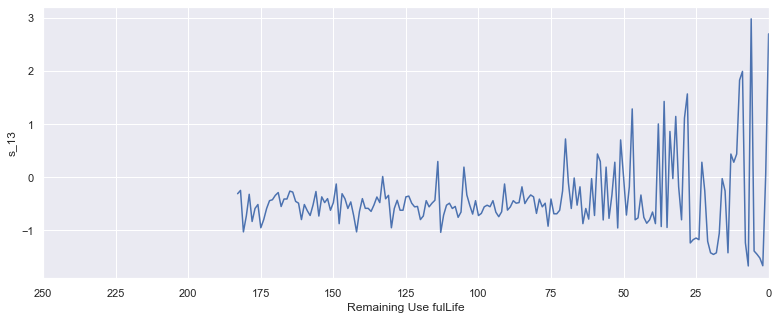

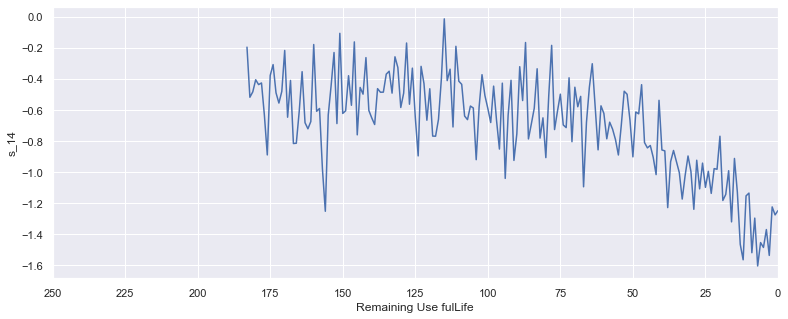

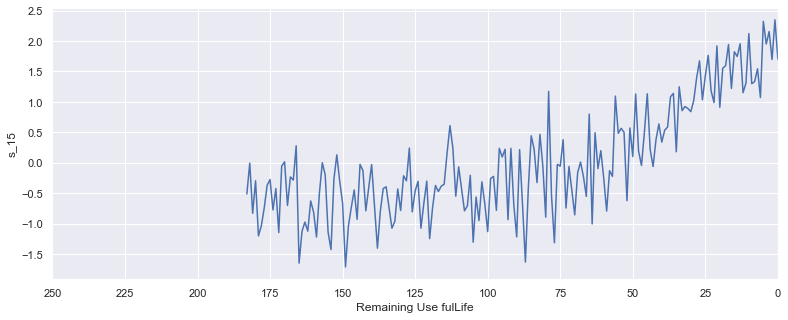

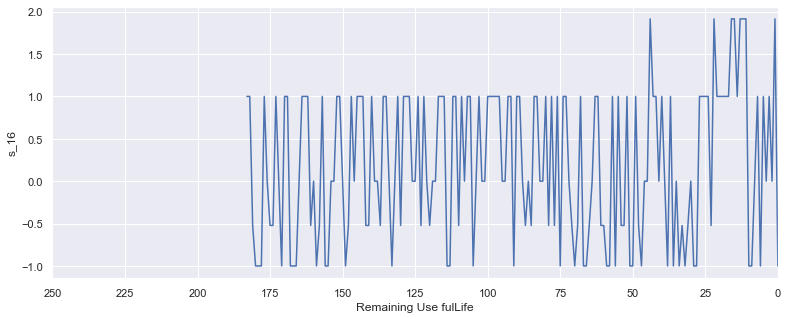

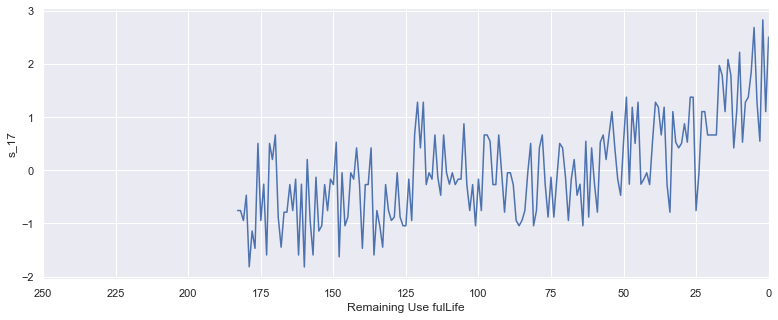

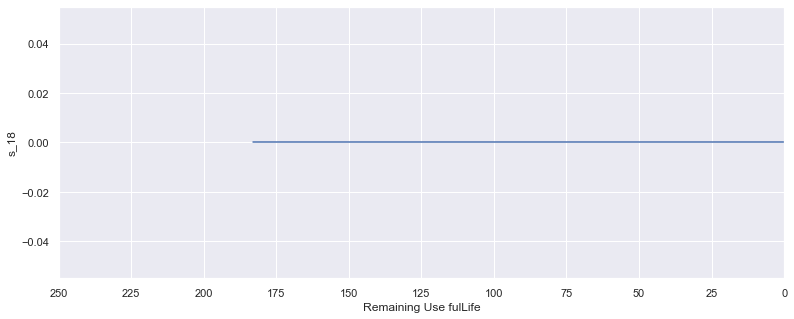

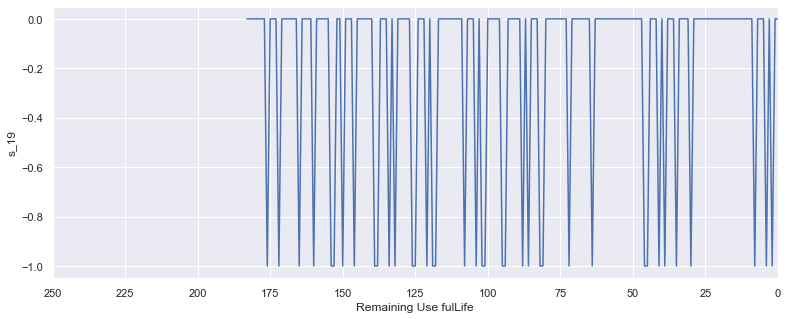

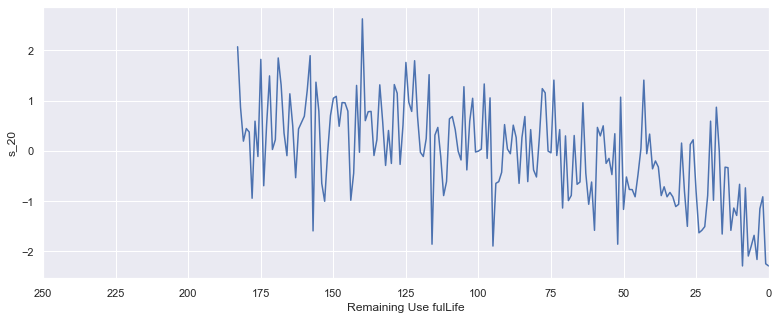

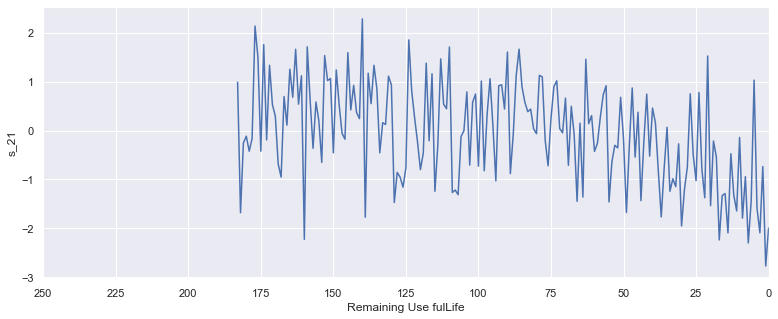

In [50]:
for sensor in sensor_names:
    plot_signal(X_train_condition_scaled, sensor, unit_nr=10)

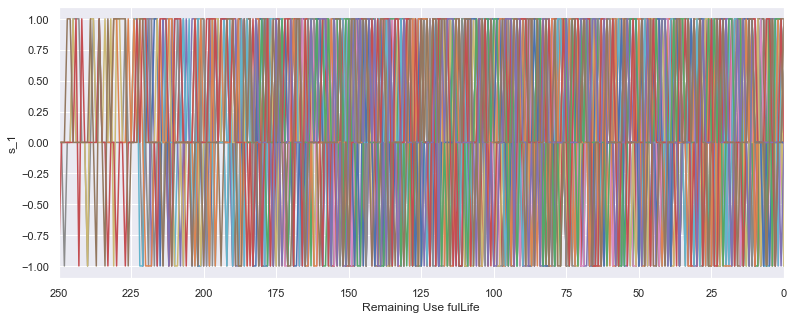

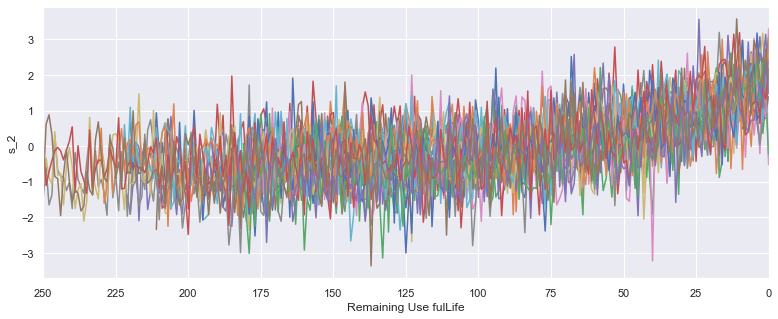

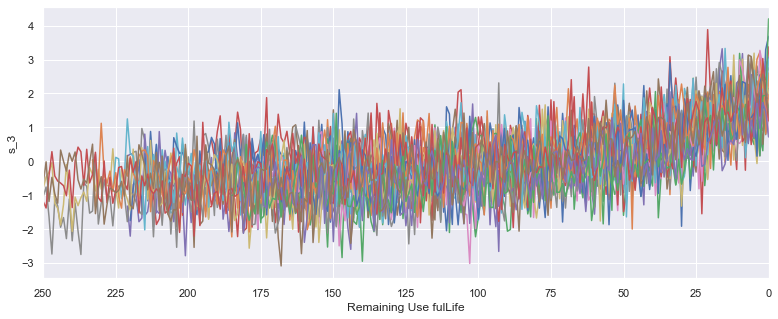

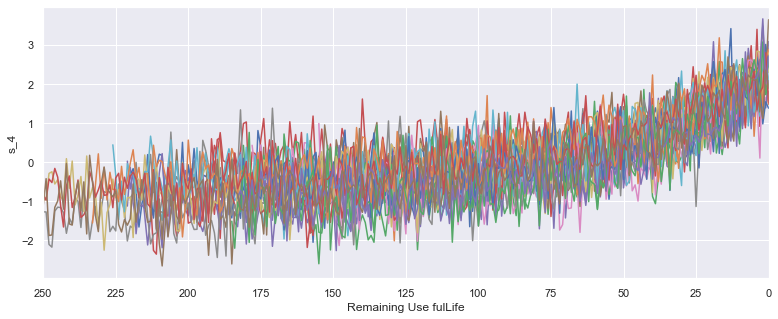

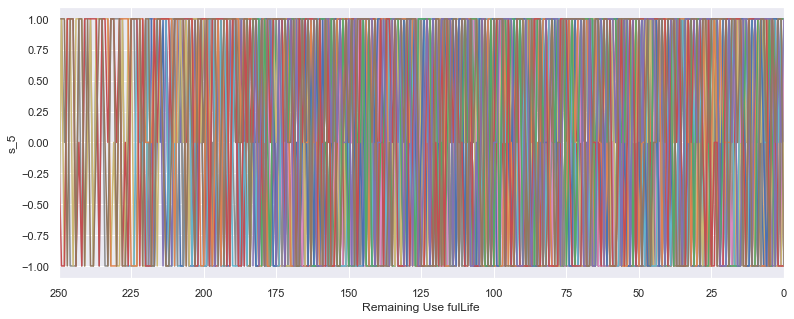

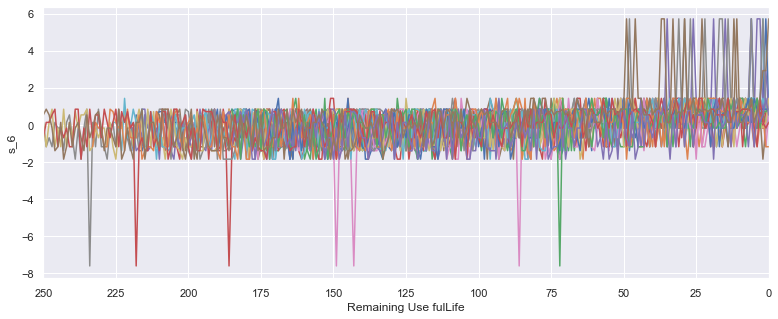

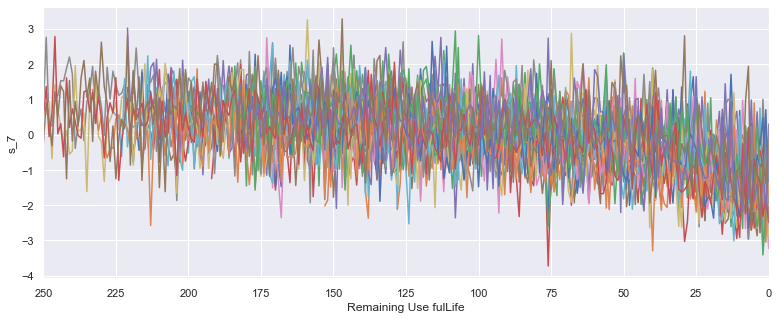

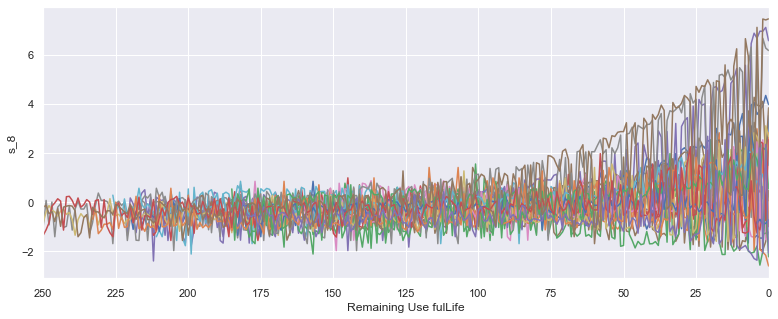

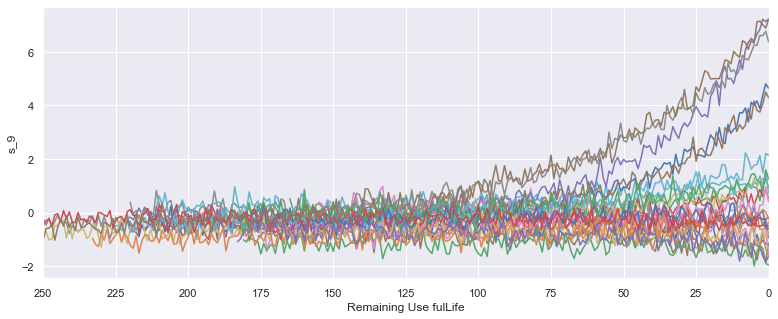

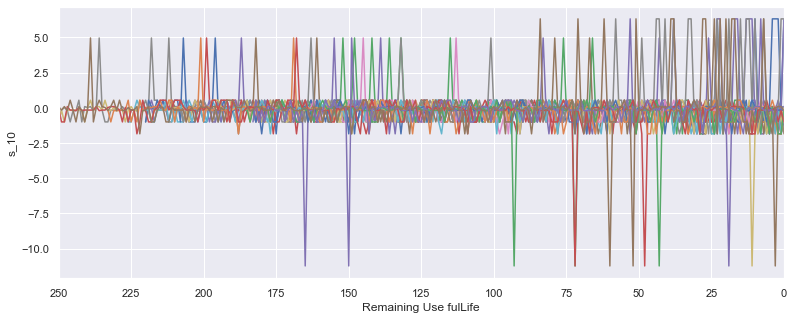

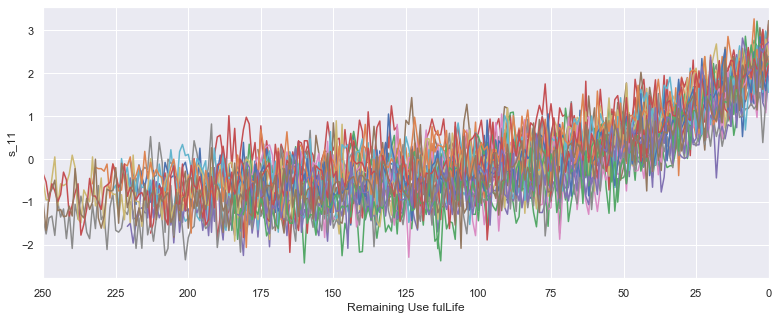

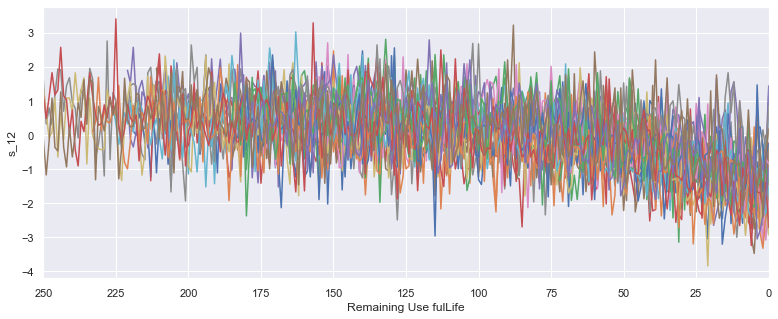

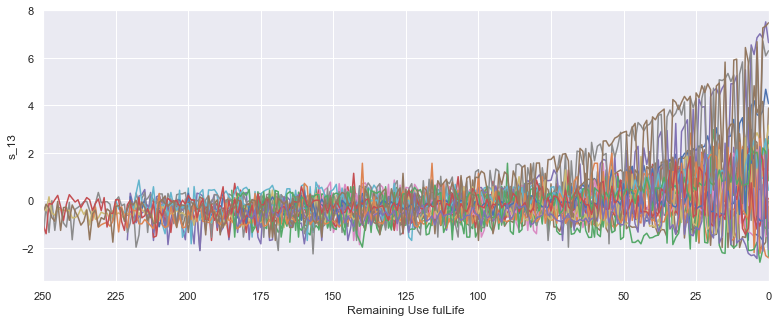

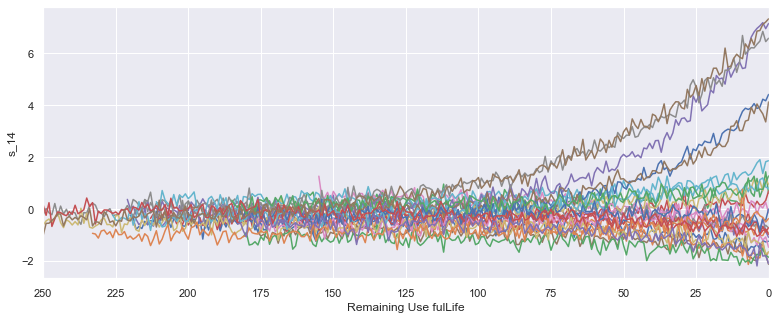

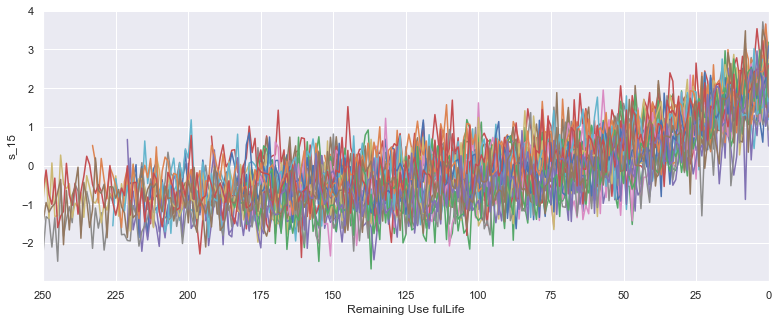

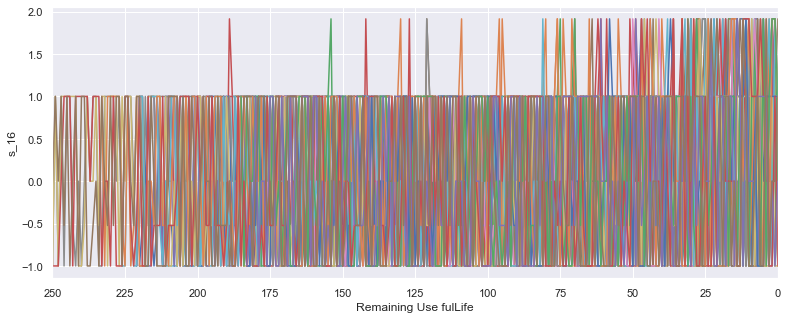

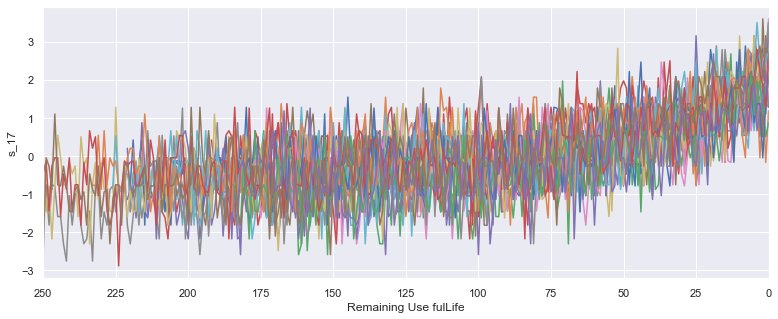

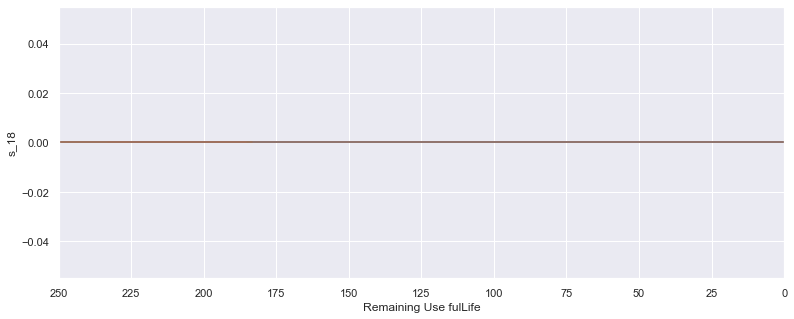

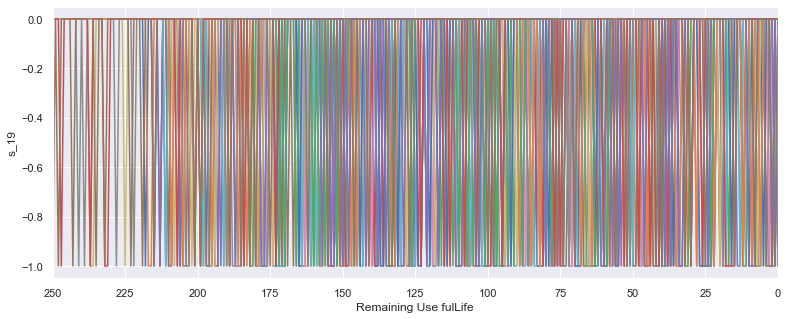

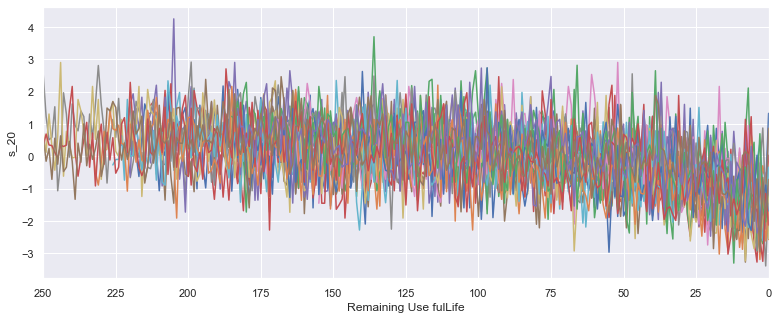

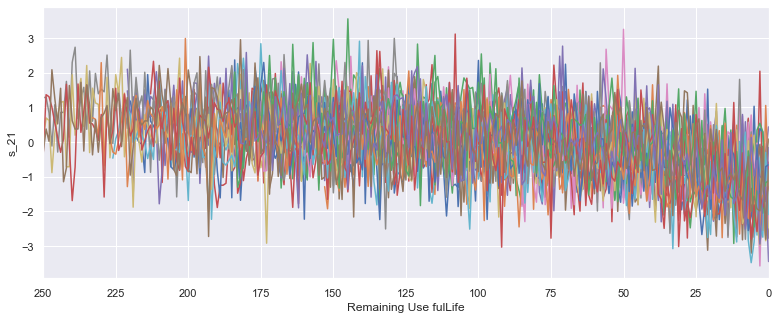

In [51]:
for sensor in sensor_names:
    plot_signal(X_train_condition_scaled, sensor)

['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'] seem good, let's fit an MLP with those

### MLP with remaining sensors

In [52]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

In [53]:
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]
drop_sensors

['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

In [54]:
split_result = train_val_group_split(X_train_condition_scaled, y_train_clipped, gss, train['unit_nr'], print_groups=False)
X_train_split_condition_scaled, y_train_clipped_split_condition_scaled = split_result[:2]
X_val_split_condition_scaled, y_val_clipped_split_condition_scaled = split_result[2:]

In [55]:
# we have to redefine our model as our inputs changed
input_dim = len(X_train_split_condition_scaled[remaining_sensors].columns)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [56]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('condition_normalized_weights_remaining_sensors.h5')

In [57]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('condition_normalized_weights_remaining_sensors.h5')

history = model.fit(X_train_split_condition_scaled[remaining_sensors], y_train_clipped_split_condition_scaled,
                    validation_data=(X_val_split_condition_scaled[remaining_sensors], y_val_clipped_split_condition_scaled),
                    epochs=epochs)

Train on 43464 samples, validate on 10295 samples
Epoch 1/20
43464/43464 [==============================] - 3s 77us/sample - loss: 1181.8502 - val_loss: 411.0403
Epoch 2/20
43464/43464 [==============================] - 3s 62us/sample - loss: 418.5440 - val_loss: 404.8830
Epoch 3/20
43464/43464 [==============================] - 3s 63us/sample - loss: 394.7535 - val_loss: 381.5364
Epoch 4/20
43464/43464 [==============================] - 3s 64us/sample - loss: 386.4557 - val_loss: 403.4866
Epoch 5/20
43464/43464 [==============================] - 3s 63us/sample - loss: 383.7353 - val_loss: 412.6303
Epoch 6/20
43464/43464 [==============================] - 3s 63us/sample - loss: 381.2500 - val_loss: 396.9577
Epoch 7/20
43464/43464 [==============================] - 3s 65us/sample - loss: 380.9630 - val_loss: 406.8574
Epoch 8/20
43464/43464 [==============================] - 3s 64us/sample - loss: 379.6207 - val_loss: 379.7820
Epoch 9/20
43464/43464 [==============================] - 3s 

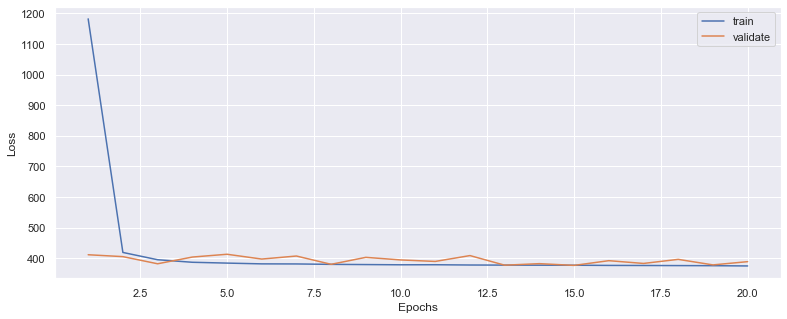

In [58]:
plot_loss(history)

In [59]:
# predict and evaluate
y_hat_train = model.predict(X_train_condition_scaled[remaining_sensors])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = model.predict(X_test_condition_scaled[remaining_sensors])
evaluate(y_test, y_hat_test)

train set RMSE:19.35447487320054, R2:0.7842178390649497
test set RMSE:29.36496528407863, R2:0.7018485932169383


This is already a (32.642 - 29.364) / 32.642 * 100 = 10.04% improvement over our baseline model. Let's see if we can improve this even further

# Lagged variables

In [60]:
def add_specific_lags(df_input, list_of_lags, columns):
    df = df_input.copy()
    for i in list_of_lags:
        lagged_columns = [col + '_lag_{}'.format(i) for col in columns]
        df[lagged_columns] = df.groupby('unit_nr')[columns].shift(i)
    df.dropna(inplace=True)
    return df

In [61]:
specific_lags = [1,2,3,4,5,10,20]  # laggs which worked well in the time series solution for FD001

In [62]:
# prep data
X_train_condition = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_condition = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, remaining_sensors)

X_train_condition_scaled_lagged = add_specific_lags(X_train_condition_scaled, specific_lags, remaining_sensors)
X_test_condition_scaled_lagged = add_specific_lags(X_test_condition_scaled, specific_lags, remaining_sensors)

X_train_condition_scaled_lagged.drop(index_names+setting_names+['op_cond', 'RUL'], axis=1, inplace=True)
X_test_condition_scaled_lagged = X_test_condition_scaled_lagged.drop(['time_cycles', 'op_cond']+setting_names, axis=1).groupby('unit_nr').last().copy()

idx = X_train_condition_scaled_lagged.index
y_train_clipped_lagged = y_train_clipped.iloc[idx]

split_result = train_val_group_split(X_train_condition_scaled_lagged, y_train_clipped_lagged, gss, train.iloc[idx]['unit_nr'], print_groups=False)
X_train_split_condition_scaled_lagged, y_train_clipped_split_lagged = split_result[:2]
X_val_split_condition_scaled_lagged, y_val_clipped_split_lagged = split_result[2:]

In [63]:
input_dim = len(X_train_split_condition_scaled_lagged.columns)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [64]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('specific_lagged_weights.h5')

In [65]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('specific_lagged_weights.h5')
epochs=20

history = model.fit(X_train_split_condition_scaled_lagged, y_train_clipped_split_lagged,
                    validation_data=(X_val_split_condition_scaled_lagged, y_val_clipped_split_lagged),
                    epochs=epochs)

Train on 39304 samples, validate on 9255 samples
Epoch 1/20
39304/39304 [==============================] - 4s 89us/sample - loss: 1091.9965 - val_loss: 395.2671
Epoch 2/20
39304/39304 [==============================] - 3s 76us/sample - loss: 405.9822 - val_loss: 391.6769
Epoch 3/20
39304/39304 [==============================] - 3s 73us/sample - loss: 372.8363 - val_loss: 359.2979
Epoch 4/20
39304/39304 [==============================] - 3s 72us/sample - loss: 358.3468 - val_loss: 364.7326
Epoch 5/20
39304/39304 [==============================] - 3s 72us/sample - loss: 347.8953 - val_loss: 341.9608
Epoch 6/20
39304/39304 [==============================] - 3s 72us/sample - loss: 340.9726 - val_loss: 370.3379
Epoch 7/20
39304/39304 [==============================] - 3s 72us/sample - loss: 336.6707 - val_loss: 341.9091
Epoch 8/20
39304/39304 [==============================] - 3s 73us/sample - loss: 331.3821 - val_loss: 349.8949
Epoch 9/20
39304/39304 [==============================] - 3s 7

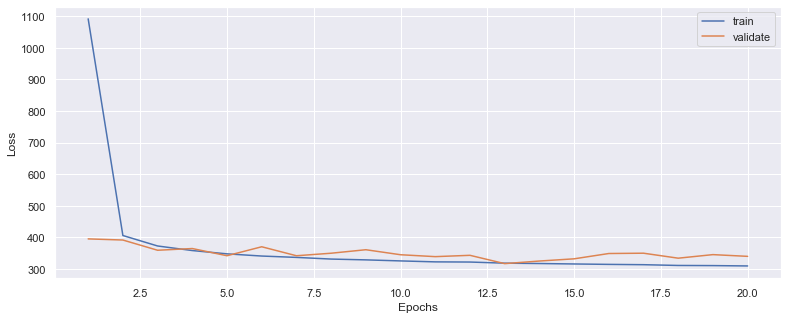

In [66]:
plot_loss(history)

In [67]:
# predict and evaluate
y_hat_train = model.predict(X_train_condition_scaled_lagged)
evaluate(y_train_clipped_lagged, y_hat_train, 'train')

y_hat_test = model.predict(X_test_condition_scaled_lagged)
evaluate(y_test, y_hat_test)

train set RMSE:17.572959256116462, R2:0.8236048587786006
test set RMSE:29.075227321534157, R2:0.7077031620947969


We've gained a slight improvement. However, the model seems to start overfitting after a few epochs, we'll try to combat this later. I've tried implementing early stopping, but this results in a different number of epochs across data splits for the hyperparameter tuning we’ll perform near the end, making it difficult to select the number of epochs for the final model

In [68]:
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.load_weights('specific_lagged_weights.h5')

# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# history = model.fit(X_train_split_condition_scaled_lagged, y_train_clipped_split_lagged,
#                     validation_data=(X_val_split_condition_scaled_lagged, y_val_clipped_split_lagged),
#                     callbacks=[callback],
#                     epochs=epochs)

In [69]:
# plot_loss(history)

In [70]:
# # predict and evaluate
# y_hat_train = model.predict(X_train_condition_scaled_lagged)
# evaluate(y_train_clipped_lagged, y_hat_train, 'train')

# y_hat_test = model.predict(X_test_condition_scaled_lagged)
# evaluate(y_test, y_hat_test)

#### eventhough validation loss is lower than without early stopping, performance is slightly worse

# Stationarity and smoothing

In [71]:
from statsmodels.tsa.stattools import adfuller

def find_max_diff(series):
    maxdiff = 0
    do = True
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series, maxlag=1)
    if pvalue < 0.05:
        do = False
    
    while do:
        maxdiff += 1
        adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series.diff(maxdiff).dropna(), maxlag=1)
        if pvalue < 0.05:  # if significant, stop differencing and testing for stationarity
            do = False
    return maxdiff


def make_stationary(df_input, columns):
    df = df_input.copy()
    for unit_nr in range(1, df['unit_nr'].max()+1):
        for col in columns:
            maxdiff = find_max_diff(df.loc[df['unit_nr']==unit_nr, col])
            if maxdiff > 0:
                df.loc[df['unit_nr']==unit_nr, col] = df.loc[df['unit_nr']==unit_nr, col].diff(maxdiff)
    df.dropna(inplace=True)
    return df

Original signal assumed stationary?  True


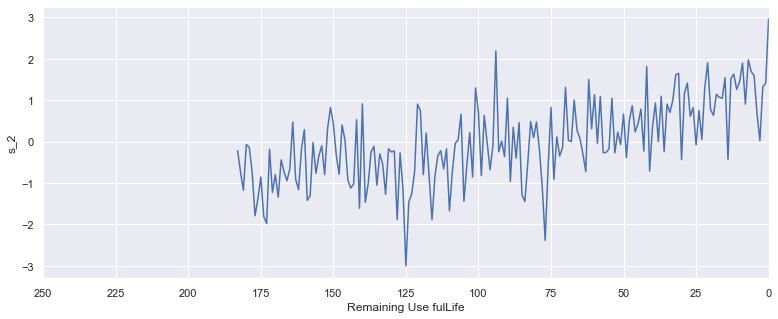

In [72]:
# stationarity after condition based standardization
X_train_condition = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_condition = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_condition_scaled, _ = condition_scaler(X_train_condition, X_test_condition, remaining_sensors)


adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(
                                            X_train_condition_scaled.loc[X_train_condition_scaled['unit_nr'] == 10,'s_2'], 
                                            maxlag=1)
print('Original signal assumed stationary? ', pvalue < 0.05)
plot_signal(X_train_condition_scaled, 's_2', 10)

### Exponential smoothing

Smoothed signal assumed stationary?  False


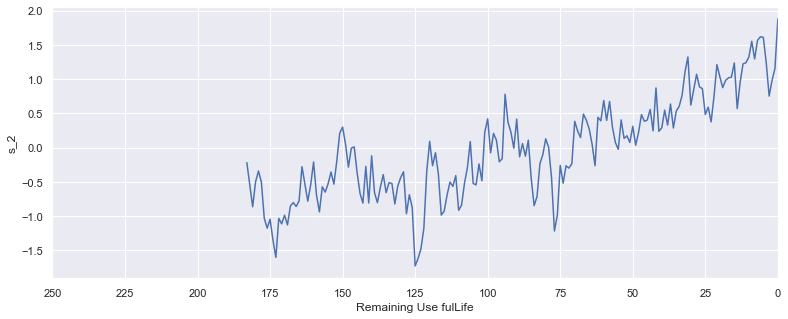

In [73]:
# https://github.com/pandas-dev/pandas/issues/16037
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

# smaller values of alpha provide a stronger filter effect
X_train_condition_scaled_smoothed = X_train_condition_scaled.copy()
X_train_condition_scaled_smoothed[remaining_sensors] = X_train_condition_scaled_smoothed.groupby(
                                                    'unit_nr')[remaining_sensors].apply(lambda x: x.ewm(alpha=0.4).mean())

# Stationarity after condition based standardization and smoothing
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(
                            X_train_condition_scaled_smoothed.loc[X_train_condition_scaled_smoothed['unit_nr'] == 10,'s_2'],
                            maxlag=1)
print('Smoothed signal assumed stationary? ', pvalue < 0.05)
plot_signal(X_train_condition_scaled_smoothed, 's_2', 10)


Adding smoothing has a big effect on the rest of the preprocessing pipeline. The smoothing factor affects when stationarity is reached. As a side effect of making the data stationary we sometimes drop a row which became NaN, which in turn affects how much lags can be added. As adding lags also introduces rows with NaN which get dropped, having either the smoothing value to strong or the nr of lags too high results in dropping engines from the dataframe completely, which we need to avoid  
with specific_lags = [1,2,3,4,5,10,20], alpha values below 0.69 cause make stationary to drop all rows of some test engines completetly. Alpha values below 0.21 cause make_stationary to return an error, max_lags is too high, but we can't set it any lower than 1 or it will have no effect..  
In the end I chose to ditch make_stationary, as a stronger filtered signal allows for better model performance

In [74]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [75]:
# prep data
X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

# one drawback, a low alpha value (stronger filter) will make the addfuller test in make_stationary error
# the lowest alpha value I could use on both train and test set was 0.21
# alpha has to be >= 0.69 to keep add_specific_lags from throwing away entire engines
X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

# X_train_interim = make_stationary(X_train_interim, remaining_sensors)
# X_test_interim = make_stationary(X_test_interim, remaining_sensors)

X_train_interim = add_specific_lags(X_train_interim, specific_lags, remaining_sensors)
X_test_interim = add_specific_lags(X_test_interim, specific_lags, remaining_sensors)

X_train_smooth_lagged = X_train_interim.drop(index_names+setting_names+['op_cond', 'RUL'], axis=1)
X_test_smooth_lagged = X_test_interim.drop(['time_cycles', 'op_cond']+setting_names, 
                                      axis=1).groupby('unit_nr').last().copy()

idx = X_train_smooth_lagged.index
y_train_clipped_lagged = y_train_clipped.iloc[idx]

In [76]:
split_result = train_val_group_split(X_train_smooth_lagged, y_train_clipped_lagged, gss, train.iloc[idx]['unit_nr'], print_groups=False)
X_train_split_smooth_lagged, y_train_clipped_split_lagged = split_result[:2]
X_val_split_smooth_lagged, y_val_clipped_split_lagged = split_result[2:]

In [77]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('specific_lagged_weights.h5')


history = model.fit(X_train_split_smooth_lagged, y_train_clipped_split_lagged,
                    validation_data=(X_val_split_smooth_lagged, y_val_clipped_split_lagged),
                    epochs=epochs)

Train on 39304 samples, validate on 9255 samples
Epoch 1/20
39304/39304 [==============================] - 5s 121us/sample - loss: 1013.7095 - val_loss: 317.1253
Epoch 2/20
39304/39304 [==============================] - 3s 79us/sample - loss: 309.3560 - val_loss: 318.9989
Epoch 3/20
39304/39304 [==============================] - 3s 73us/sample - loss: 296.3867 - val_loss: 307.4838
Epoch 4/20
39304/39304 [==============================] - 3s 74us/sample - loss: 289.7749 - val_loss: 305.8332
Epoch 5/20
39304/39304 [==============================] - 3s 77us/sample - loss: 284.6312 - val_loss: 301.6109
Epoch 6/20
39304/39304 [==============================] - 3s 73us/sample - loss: 279.9542 - val_loss: 329.2871
Epoch 7/20
39304/39304 [==============================] - 3s 72us/sample - loss: 277.1237 - val_loss: 295.3004
Epoch 8/20
39304/39304 [==============================] - 3s 73us/sample - loss: 272.8670 - val_loss: 312.0414
Epoch 9/20
39304/39304 [==============================] - 3s 

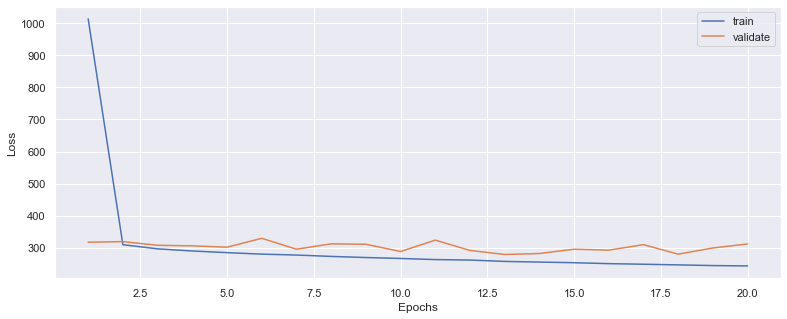

In [78]:
plot_loss(history)

In [79]:
# predict and evaluate
y_hat_train = model.predict(X_train_smooth_lagged)
evaluate(y_train_clipped_lagged, y_hat_train, 'train')

y_hat_test = model.predict(X_test_smooth_lagged)
evaluate(y_test, y_hat_test)

train set RMSE:15.916032412669667, R2:0.85530069539296
test set RMSE:27.852681524828476, R2:0.731767185824673


# Testing epochs and val loss here before hyperparameter tuning
Using the same model I crank up the epochs to see how the validation loss will behave. If it remains relatively constant for higher epochs it means we can higher number of epochs during hyperparameter tuning without too much worry for overfitting

In [81]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('specific_lagged_weights.h5')
epochs=50  # used to be 20

# X_train_array = X_train_split_condition_scaled_lagged.values
# y_train_array = y_train_clipped_split_lagged.values

# X_val_array = X_val_split_condition_scaled_lagged.values
# y_val_array = y_val_clipped_split_lagged.values

history = model.fit(X_train_split_smooth_lagged, y_train_clipped_split_lagged,
                    validation_data=(X_val_split_smooth_lagged, y_val_clipped_split_lagged),
#                     callbacks=[callback],
                    epochs=epochs)

Train on 39304 samples, validate on 9255 samples
Epoch 1/50
39304/39304 [==============================] - 3s 82us/sample - loss: 1013.7095 - val_loss: 317.1253
Epoch 2/50
39304/39304 [==============================] - 3s 64us/sample - loss: 309.3560 - val_loss: 318.9989
Epoch 3/50
39304/39304 [==============================] - 3s 68us/sample - loss: 296.3867 - val_loss: 307.4838
Epoch 4/50
39304/39304 [==============================] - 3s 65us/sample - loss: 289.7749 - val_loss: 305.8332
Epoch 5/50
39304/39304 [==============================] - 2s 61us/sample - loss: 284.6312 - val_loss: 301.6109
Epoch 6/50
39304/39304 [==============================] - 2s 62us/sample - loss: 279.9542 - val_loss: 329.2871
Epoch 7/50
39304/39304 [==============================] - 3s 72us/sample - loss: 277.1237 - val_loss: 295.3004
Epoch 8/50
39304/39304 [==============================] - 3s 74us/sample - loss: 272.8670 - val_loss: 312.0414
Epoch 9/50
39304/39304 [==============================] - 2s 6

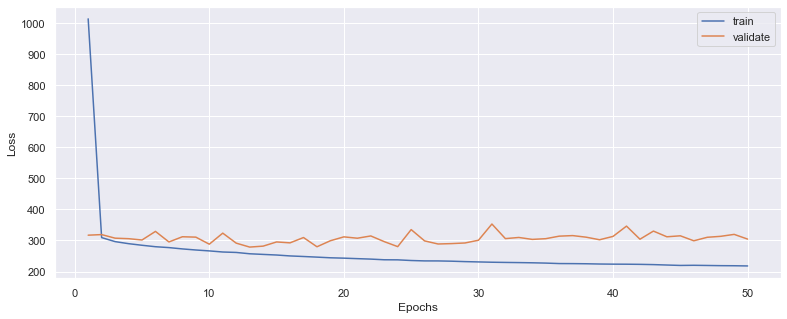

In [82]:
plot_loss(history)

In [83]:
# predict and evaluate
y_hat_train = model.predict(X_train_condition_scaled_lagged)
evaluate(y_train_clipped_lagged, y_hat_train, 'train')

y_hat_test = model.predict(X_test_condition_scaled_lagged)
evaluate(y_test, y_hat_test)

train set RMSE:19.784558538181454, R2:0.7764114588121707
test set RMSE:32.17059484378398, R2:0.6421540867400053


Test RMSE has increased significantly, but it should be okay to tune between 10-30 epochs. We now have all the preprocessing components to start hyper parameter tuning

# Hyper parameter tuning

parameters to tune:
    - alpha, filter strength
    - lags (I choose to not tune this parameter)
    - epochs
    - number of layers (I choose to not tune this parameter)
    - nodes per layer
    - dropout
    - optimizer, learning rate (I choose to not tune this parameter)
    - activation function
    - batch size

We can't use hyperparameter tuning like we did for the random forest. We'll write custom code since the parameters defined above need to be tuned in different places, e.g. data, NN architecture and fitting. 

In [84]:
# earlier testing revealed lower alpha's perform better, so we can ditch a few high ones to reduce the search space
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)
epoch_list = list(np.arange(10,30+1,5))
nodes_list = [[16, 32, 64], [32, 64, 128], [64, 128, 256], [128, 256, 512]]

# lowest dropout=0.1, because I know zero dropout will yield better training results but worse generalization (overfitting)
dropouts = list(np.arange(1,5)/10)  

# earlier testing revealed relu performed significantly worse, so I removed it from the options
activation_functions = ['tanh', 'sigmoid']  
batch_size_list = [32, 64, 128, 256, 512]

tuning_options = np.prod([len(alpha_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list)])
tuning_options

6400

In [85]:
# random.sample(nodes_list, 1)[0]  # check if working as expected

In [86]:
def prep_data(df_train, train_label, df_test, remaining_sensors, lags, alpha, n=0):
    X_train_interim = add_operating_condition(df_train)
    X_test_interim = add_operating_condition(df_test)

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, n, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, n, alpha)

    X_train_interim = add_specific_lags(X_train_interim, lags, remaining_sensors)
    X_test_interim = add_specific_lags(X_test_interim, lags, remaining_sensors)

    X_train_interim.drop(index_names+setting_names+['op_cond', 'RUL'], axis=1, inplace=True)
    X_test_interim = X_test_interim.drop(
        ['time_cycles', 'op_cond']+setting_names, axis=1).groupby('unit_nr').last().copy()

    idx = X_train_interim.index
    train_label = train_label.iloc[idx]
    return X_train_interim, train_label, X_test_interim, idx

In [87]:
def create_model(input_dim, nodes_per_layer, dropout, activation, weights_file):
    model = Sequential()
    model.add(Dense(nodes_per_layer[0], input_dim=input_dim, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nodes_per_layer[1], activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nodes_per_layer[2], activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [88]:
# random grid search takes significant time, set iterations to a higher number if you truly want to tune parameters
ITERATIONS = 10 

In [89]:
%%time
results = pd.DataFrame(columns=['MSE', 'std_MSE', # bigger std means less robust
                                'alpha', 'epochs', 
                                'nodes', 'dropout', 
                                'activation', 'batch_size'])  
weights_file = 'mlp_hyper_parameter_weights.h5'
specific_lags = [1,2,3,4,5,10,20]

for i in range(ITERATIONS):
    if ITERATIONS < 10:
        print('iteration ', i+1)
    elif ((i+1) % 10 == 0):
        print('iteration ', i+1)
    
    mse = []
    
    # init parameters
    alpha = random.sample(alpha_list, 1)[0]
    epochs = random.sample(epoch_list, 1)[0]
    nodes_per_layer = random.sample(nodes_list, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    
    # create dataset
    df_train, train_label, _, idx = prep_data(df_train=train.drop(drop_sensors, axis=1),
                                            train_label=y_train_clipped,
                                            df_test=test.drop(drop_sensors, axis=1), 
                                            remaining_sensors=remaining_sensors,
                                            lags=specific_lags, 
                                            alpha=alpha)
    
    # create model
    input_dim = len(df_train.columns)
    model = create_model(input_dim, nodes_per_layer, dropout, activation, weights_file)
    
    
    # create train-validation split
    gss_search = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    for idx_train, idx_val in gss_search.split(df_train, train_label, groups=train.iloc[idx]['unit_nr']):
        X_train_split = df_train.iloc[idx_train].copy()
        y_train_split = train_label.iloc[idx_train].copy()
        X_val_split = df_train.iloc[idx_val].copy()
        y_val_split = train_label.iloc[idx_val].copy()
        
        # train and evaluate model
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(X_train_split, y_train_split,
                            validation_data=(X_val_split, y_val_split),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)
        
        mse.append(history.history['val_loss'][-1])
    
    
    # append results
    d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha, 
         'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size}
    results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)

iteration  10
iteration  20
iteration  30
iteration  40
iteration  50
iteration  60
iteration  70
iteration  80
iteration  90
iteration  100
Wall time: 2h 44min 6s


In [90]:
# 10 runs took about 20 minutes

# best
# mse=177.60, std_mse=8.03, alpha=0.05, epochs=[12,6,12], nodes=[128,256,512], dropout=0.1, activation=sigmoid, batch_size=64
# mse=171.60, std_mse=8.55, alpha=0.-5, epochs=10, nodes=[64,128,256], dropout=0.2, activation=tanh, batchsize=64
results.sort_values('MSE')

MSE     std_MSE  alpha epochs            nodes  dropout  \
0    171.190213    8.551950   0.05     10   [64, 128, 256]      0.2   
47   171.988567    7.271708   0.05     15   [64, 128, 256]      0.3   
42   173.627079   14.040434   0.05     15  [128, 256, 512]      0.1   
56   177.484374   10.385783   0.05     20  [128, 256, 512]      0.2   
5    178.846867   13.975968   0.05     10  [128, 256, 512]      0.1   
..          ...         ...    ...    ...              ...      ...   
61   896.928560   25.946362   0.30     10   [64, 128, 256]      0.3   
41  2069.557012  102.442470   0.10     10     [16, 32, 64]      0.2   
62  2145.392881  108.331703   0.40     10     [16, 32, 64]      0.3   
40  2253.954802   91.814467   0.01     20     [16, 32, 64]      0.1   
73  3640.334589  145.659633   0.10     10     [16, 32, 64]      0.2   

   activation batch_size  
0        tanh         64  
47       tanh        256  
42       tanh        512  
56       tanh         64  
5     sigmoid        128  
..        ...        ...  
61    sigmoid        512  
41       tanh        512  
62       tanh        512  
40    sigmoid        512  
73    sigmoid        512  

[100 rows x 8 columns]

# The Result

In [91]:
alpha = 0.05
epochs = 10 
specific_lags = [1,2,3,4,5,10,20]
nodes = [64, 128, 256]
dropout = 0.2
activation = 'tanh'
batch_size = 64


df_train, train_label, df_test, _ = prep_data(df_train=train.drop(drop_sensors, axis=1),
                                        train_label=y_train_clipped,
                                        df_test=test.drop(drop_sensors, axis=1), 
                                        remaining_sensors=remaining_sensors,
                                        lags=specific_lags, 
                                        alpha=alpha)

input_dim = len(df_train.columns)
weights_file = 'fd002_model_weights.h5'
final_model = create_model(input_dim, 
                           nodes_per_layer=nodes, 
                           dropout=dropout, 
                           activation=activation, 
                           weights_file=weights_file)

final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.load_weights(weights_file)

final_model.fit(df_train, train_label,
               epochs=epochs,
               batch_size=batch_size)

Train on 48559 samples
Epoch 1/10
48559/48559 [==============================] - 3s 68us/sample - loss: 1419.7741
Epoch 2/10
48559/48559 [==============================] - 3s 57us/sample - loss: 218.6466
Epoch 3/10
48559/48559 [==============================] - 3s 56us/sample - loss: 204.1322
Epoch 4/10
48559/48559 [==============================] - 3s 55us/sample - loss: 205.3922
Epoch 5/10
48559/48559 [==============================] - 3s 57us/sample - loss: 198.1424
Epoch 6/10
48559/48559 [==============================] - 3s 55us/sample - loss: 198.7674
Epoch 7/10
48559/48559 [==============================] - 3s 57us/sample - loss: 196.1557
Epoch 8/10
48559/48559 [==============================] - 3s 58us/sample - loss: 193.1338
Epoch 9/10
48559/48559 [==============================] - 3s 55us/sample - loss: 194.0049
Epoch 10/10
48559/48559 [==============================] - 3s 55us/sample - loss: 192.6580


In [92]:
# predict and evaluate
y_hat_train = final_model.predict(df_train)
evaluate(train_label, y_hat_train, 'train')

y_hat_test = final_model.predict(df_test)
evaluate(y_test, y_hat_test)

train set RMSE:12.82085148416833, R2:0.9061075756420954
test set RMSE:25.352943890689797, R2:0.7777536332595578


Note, you results may vary depending on how many iterations of random gridsearch you've run. During each iteration multiple random samples are taken, affecting which state is used for the random initialization of model weights for the final model.

A RMSE of 25.353 is a (32.642 - 25.353) / 32.642 * 100 = 22.33% improvement over our baseline model, neat!  
Note, this could improve even further when running more tuning iterations. In addition, you could also tune the layers of the NN, number of lags used, optimizer and learning rate.